<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [46]</a>'.</span>

<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [46]</a>'.</span>

In [1]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def load_results(file_path):
    """Load results from JSON file."""
    with open(file_path, 'r') as f:
        return json.load(f)

In [3]:
def calculate_accuracy(predictions, ground_truths):
    """Calculate accuracy between predictions and ground truths."""
    # Convert Series to lists to avoid pandas Series ambiguity
    if hasattr(predictions, 'tolist'):
        predictions = predictions.tolist()
    if hasattr(ground_truths, 'tolist'):
        ground_truths = ground_truths.tolist()
    
    # Calculate accuracy
    correct = sum(1 for p, g in zip(predictions, ground_truths) if str(p) == str(g))
    return correct / len(predictions) if predictions else 0

In [4]:
def calculate_error_metrics(predictions, ground_truths, category=None):
    """
    Calculate MAE, MSE, and RMSE between predictions and ground truths.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        category: Optional category name for the analysis
        
    Returns:
        Dictionary containing MAE, MSE, and RMSE
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate differences
    differences = [abs(p - t) for p, t in zip(preds, truths)]
    
    # Calculate metrics
    mae = sum(differences) / len(differences)
    mse = sum(d * d for d in differences) / len(differences)
    rmse = mse ** 0.5
    
    result = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'sample_size': len(differences)
    }
    
    if category:
        result['category'] = category
        
    return result

In [5]:
def calculate_off_by_n_accuracy(predictions, ground_truths, n=1):
    """
    Calculate accuracy within n counts of the ground truth.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        n: Maximum allowed difference (default=1)
        
    Returns:
        Dictionary containing accuracy for each tolerance level up to n
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    results = {}
    # Cumulative accuracies
    for tolerance in range(n + 1):
        correct = sum(1 for p, t in zip(preds, truths) if abs(p - t) <= tolerance)
        accuracy = correct / len(preds)
        results[f'off_by_{tolerance}'] = accuracy

    # Individual accuracies
    for tolerance in range(n + 1):
        if tolerance == 0:
            results[f'exactly_{tolerance}'] = results[f'off_by_{tolerance}']
        else:
            # Count only predictions that are exactly off by tolerance
            exact_count = sum(1 for p, t in zip(preds, truths) if abs(p - t) == tolerance)
            results[f'exactly_{tolerance}'] = exact_count / len(preds)

    return results

In [6]:
def analyze_error_distribution(predictions, ground_truths):
    """
    Analyze the distribution of counting errors.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        
    Returns:
        Dictionary containing error distribution statistics
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate errors
    errors = [p - t for p, t in zip(preds, truths)]
    
    # Calculate statistics
    mean_error = sum(errors) / len(errors)
    median_error = sorted(errors)[len(errors) // 2]
    
    # Count over/under predictions
    over_count = sum(1 for e in errors if e > 0)
    under_count = sum(1 for e in errors if e < 0)
    exact_count = sum(1 for e in errors if e == 0)
    
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'over_count': over_count,
        'under_count': under_count,
        'exact_count': exact_count,
        'error_distribution': errors
    }

In [7]:
def calculate_random_baseline(min_count=0, max_count=10, n=2):
    """
    Calculate random baseline probabilities for off-by-n accuracy.
    
    Args:
        min_count: Minimum possible count (default=0)
        max_count: Maximum possible count (default=10)
        n: Maximum allowed difference for off-by-n (default=2)
        
    Returns:
        Dictionary containing baseline probabilities for each tolerance level
    """
    total_possible_counts = max_count - min_count + 1
    baseline_probs = {}
    
    # Calculate for each tolerance level
    for tolerance in range(n + 1):
        # For each possible count, calculate how many other counts would be considered correct
        correct_counts = 0
        for true_count in range(min_count, max_count + 1):
            # Count how many predictions would be considered correct for this true count
            for pred_count in range(min_count, max_count + 1):
                if abs(pred_count - true_count) <= tolerance:
                    correct_counts += 1
        
        # Calculate probability
        # For each true count, we have total_possible_counts possible predictions
        total_possible_predictions = total_possible_counts * total_possible_counts
        probability = correct_counts / total_possible_predictions
        
        baseline_probs[f'off_by_{tolerance}'] = probability
        
        # Calculate individual probabilities
        for tolerance in range(n + 1):
            if tolerance == 0:
                baseline_probs[f'exactly_{tolerance}'] = baseline_probs[f'off_by_{tolerance}']
            else:
                # Count only predictions that are exactly off by tolerance
                exact_counts = 0
                for true_count in range(min_count, max_count + 1):
                    for pred_count in range(min_count, max_count + 1):
                        if abs(pred_count - true_count) == tolerance:
                            exact_counts += 1
                
                baseline_probs[f'exactly_{tolerance}'] = exact_counts / (total_possible_counts * total_possible_counts)
    
    return baseline_probs

In [8]:
def analyze_results(results_file, model_name):
    """Analyze results across different dimensions with additional metrics."""
    results = load_results(results_file)
    
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    overall_accuracy = calculate_accuracy(df['model_answer'], df['ground_truth'])
    print(f"\n{model_name} Overall Accuracy: {overall_accuracy:.2%}")
    
    # 2. Overall Error Metrics
    overall_error_metrics = calculate_error_metrics(df['model_answer'], df['ground_truth'], 'Overall')
    print("\nOverall Error Metrics:")
    for metric, value in overall_error_metrics.items():
        if metric != 'category' and metric != 'sample_size':
            print(f"{metric}: {value:.2f}")
    
    # 3. Off-by-N Accuracy (Overall)
    off_by_n = calculate_off_by_n_accuracy(df['model_answer'], df['ground_truth'], n=2)
    print("\nOverall Off-by-N Accuracy:")
    for n, acc in off_by_n.items():
        print(f"{n}: {acc:.2%}")
    
    # 4. Error Distribution (Overall)
    error_dist = analyze_error_distribution(df['model_answer'], df['ground_truth'])
    print("\nOverall Error Distribution:")
    print(f"Mean Error: {error_dist['mean_error']:.2f}")
    print(f"Median Error: {error_dist['median_error']:.2f}")
    print(f"Over-counts: {error_dist['over_count']}")
    print(f"Under-counts: {error_dist['under_count']}")
    print(f"Exact counts: {error_dist['exact_count']}")
    
    # 5. Question-type Analysis
    df['question_type'] = df.apply(lambda x: int(x['question_id'].replace('Q', '')), axis=1)
    df['question_category'] = df['question_type'].map({
        1: 'Direct Recognition',
        2: 'Property Inference',
        3: 'Counterfactual'
    })

    question_accuracies = df.groupby('question_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Question Type:")
    for q_type, acc in question_accuracies.items():
        print(f"{q_type}: {acc:.2%}")
    
    # 6. Image Type Analysis
    image_type_accuracies = df.groupby('image_type').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Image Type:")
    for img_type, acc in image_type_accuracies.items():
        print(f"{img_type}: {acc:.2%}")

    # 7. Property Category Analysis
    property_accuracies = df.groupby('property_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Property Category:")
    for prop, acc in property_accuracies.items():
        print(f"{prop}: {acc:.2%}")


    # Calculate error metrics for each question category
    question_error_metrics = {}
    for q_type in df['question_category'].unique():
        q_df = df[df['question_category'] == q_type]
        question_error_metrics[q_type] = calculate_error_metrics(
            q_df['model_answer'], 
            q_df['ground_truth'],
            q_type
        )
    
    print("\nError Metrics by Question Type:")
    for q_type, metrics in question_error_metrics.items():
        print(f"\n{q_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    # Similar analysis for image types and property categories
    image_error_metrics = {}
    for i_type in df['image_type'].unique():
        i_df = df[df['image_type'] == i_type]
        image_error_metrics[i_type] = calculate_error_metrics(
            i_df['model_answer'],
            i_df['ground_truth'],
            i_type
        )
    
    print("\nError Metrics by Image Type:")
    for i_type, metrics in image_error_metrics.items():
        print(f"\n{i_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")


    property_error_metrics = {}
    for p_type in df['property_category'].unique():
        p_df = df[df['property_category'] == p_type]
        property_error_metrics[p_type] = calculate_error_metrics(
            p_df['model_answer'],
            p_df['ground_truth'],
            p_type
        )
    
    print("\nError Metrics by Property caterogry:")
    for p_type, metrics in property_error_metrics.items():
        print(f"\n{p_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    return {
        'overall': overall_accuracy,
        'overall_error_metrics': overall_error_metrics,
        'question_error_metrics': question_error_metrics,
        'off_by_n': off_by_n,
        'error_distribution': error_dist,
        'question_type': question_accuracies,
        'image_type': image_type_accuracies,
        'property': property_accuracies,
        'df': df
    }

In [9]:
def plot_results(analysis_results, model_name):
    """Create visualizations for the results."""
    # Use a simple style that's guaranteed to work
    plt.style.use('default')
    
    # Set color scheme manually
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Question Type Accuracy Plot
    question_acc = analysis_results['question_type']
    bars1 = question_acc.plot(kind='bar', ax=ax1, color=colors)
    ax1.set_title(f'{model_name}: Accuracy by Question Type', pad=20)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(question_acc):
        ax1.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # 2. Image Type Accuracy Plot
    image_acc = analysis_results['image_type']
    bars2 = image_acc.plot(kind='bar', ax=ax2, color=colors)
    ax2.set_title(f'{model_name}: Accuracy by Image Type', pad=20)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on top of bars
    for i, v in enumerate(image_acc):
        ax2.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{model_name}_analysis.png', bbox_inches='tight', dpi=300)
    plt.close()

In [10]:
# def compare_models(model_results_dict):
#     """Compare results across different models."""
#     comparison_df = pd.DataFrame({
#         model: {
#             'Overall Accuracy': results['overall'],
#             'Direct Recognition': results['question_type']['Direct Recognition'],
#             'Property Inference': results['question_type']['Property Inference'],
#             'Counterfactual': results['question_type']['Counterfactual']
#         }
#         for model, results in model_results_dict.items()
#     }).T
    
#     # Format the DataFrame to display percentages with two decimal places
#     formatted_df = comparison_df.applymap(lambda x: f"{x * 100:.2f}%")

#     print("\nModel Comparison:")
#     print(formatted_df.to_string())
    
#     # Plot model comparison
#     plt.figure(figsize=(12, 6))
#     comparison_df.plot(kind='bar')
#     plt.title('Model Comparison Across Question Types')
#     plt.xlabel('Models')
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('model_comparison.png', bbox_inches='tight', dpi=300)
#     plt.close()

In [11]:
def compare_models_extended(model_results_dict):
    """Compare results across different models for question types, image types, and property categories."""
    # Use default style
    plt.style.use('default')
    
    # Create three DataFrames - one for each category type
    question_df = pd.DataFrame({
        model: {
            'Overall Accuracy': results['overall'],
            'Direct Recognition': results['question_type']['Direct Recognition'],
            'Property Inference': results['question_type']['Property Inference'],
            'Counterfactual': results['question_type']['Counterfactual']
        }
        for model, results in model_results_dict.items()
    }).T

    image_df = pd.DataFrame({
        model: {
            'REAL': results['image_type']['REAL'],
            'ANIMATED': results['image_type']['ANIMATED'],
            'AI_GENERATED': results['image_type']['AI_GENERATED']
        }
        for model, results in model_results_dict.items()
    }).T

    # Create property category DataFrame
    property_df = pd.DataFrame({
        model: {
            # 'functional/relational': results['property']['functional/relational'],
            'physical': results['property']['physical'],
            'taxonomic': results['property']['taxonomic'],
            'functional': results['property']['functional'],
            'relational': results['property']['relational'],
            # 'taxonomic/relational': results['property']['taxonomic/relational']
        }
        for model, results in model_results_dict.items()
    }).T
    
    # Format DataFrames to display percentages
    formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")

    # Print formatted results
    print("\nModel Comparison by Question Type:")
    print(formatted_question_df.to_string())
    print("\nModel Comparison by Image Type:")
    print(formatted_image_df.to_string())
    print("\nModel Comparison by Property Category:")
    print(formatted_property_df.to_string())
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot 1: Question Types
    question_df.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Model Comparison Across Question Types', pad=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels for question types
    # for i in range(len(question_df)):
    #     for j in range(len(question_df.columns)):
    #         value = question_df.iloc[i, j]
    #         ax1.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')
    
    # Plot 2: Image Types
    image_df.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Model Comparison Across Image Types', pad=20)
    ax2.set_xlabel('')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # # Add value labels for image types
    # for i in range(len(image_df)):
    #     for j in range(len(image_df.columns)):
    #         value = image_df.iloc[i, j]
    #         ax2.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')

    # Plot 3: Property Categories
    property_df.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Model Comparison Across Property Categories', pad=20)
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_xticklabels(ax3.get_xticklabels(), ha='right')
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # # Add value labels for property categories
    # for i in range(len(property_df)):
    #     for j in range(len(property_df.columns)):
    #         value = property_df.iloc[i, j]
    #         ax3.text(i, value, f'{value:.1%}', 
    #                 ha='center', va='bottom')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('model_comparison_extended.png', bbox_inches='tight', dpi=300)
    plt.close()

    return question_df, image_df, property_df

In [12]:
# Analyze results for each model
model_results = {}

# List of result files to analyze
result_files = {
    'BLIP2-OPT-2.7B': '/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-2.7b_results.json',
    'BLIP2-OPT-6.7B': '/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-6.7b_results.json',
    'FUYU-8B': '/var/scratch/ave303/OP_bench/ORBIT_results/fuyu_8b_results.json',
    # 'BLIP2-Flan-T5-XL': '/var/scratch/ave303/OP_bench/new_results/blip2-flan-t5-xl_results.json',
    'BLIP2-FLan-T5-XXL': '/var/scratch/ave303/OP_bench/ORBIT_results/blip2-flan-t5-xxl_results.json',  
    # 'SmolVLM2-2.2B-Instruct_fp16': '/var/scratch/ave303/OP_bench/results/smolVLM2_results_1.json',
    # 'InternVL2.5-4B-MPO_fp16': '/var/scratch/ave303/OP_bench/results/InternVL2.5_results_1.json',
    'Qwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_3b_results.json',
    'Qwen2.5-VL-7B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_7b_results.json',
    'Qwen2.5-VL-32B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_32b_results.json',
    # 'Ristretto-3B_fp16': '/var/scratch/ave303/OP_bench/results/Ristretto_3b_results.json'
    # 'InternVL2.5-8B-MPO': '/var/scratch/ave303/OP_bench/new_results/InternVL2.5_results_8bMPO.json',
    'InternVL3-8B': '/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_8b.json',
    'InternVL3_14B': '/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_14b.json',
    # 'InternVL3_14B_1': '/var/scratch/ave303/OP_bench/new_results/InternVL3_results_14b_1.json',
    # 'Qwen2.5-VL-32B-Instruct_1': '/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_32b_results_1.json',
    'Gemma3-27B-it': '/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json',
    'GPT-4o-mini': '/var/scratch/ave303/OP_bench/ORBIT_results/gpt-4o-mini_results.json',
    # 'Gemma3-27B-it_1': '/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results_1.json',
    # 'Gemini2_0Flash': '/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results.json',
    # 'Gemini2_0Flash_1': '/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results1.json',
    'Spacethinker-Qwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/ORBIT_results/Spacethinker-qwen2-5-vl-3b_results.json',
    # 'SpaceThinker-Qwen2.5-VL-3B-Instruct_1': '/var/scratch/ave303/OP_bench/new_results/Spacethinker-Qwen2.5-VL_3b_results_1.json',
    # 'SpaceQwen2.5-VL-3B-Instruct': '/var/scratch/ave303/OP_bench/new_results/SpaceQwen2.5-VL_3b_results.json'
    'human_evaluation_stefano': '/var/scratch/ave303/OP_bench/ORBIT_results/human_evaluation_stefano.json',
    'human_evaluation_mehdi': '/var/scratch/ave303/OP_bench/ORBIT_results/human_evaluation_mehdi.json',
    # Add other model result files here
}

for model_name, file_path in result_files.items():
    if Path(file_path).exists():
        print(f"\nAnalyzing {model_name}...")
        results = analyze_results(file_path, model_name)
        model_results[model_name] = results
        plot_results(results, model_name)

# Calculate random baseline
random_baseline = calculate_random_baseline()
print("\nRandom Baseline Probabilities:")
for n, prob in random_baseline.items():
    print(f"{n}: {prob:.2%}")

# Compare models if we have multiple results
if len(model_results) > 1:
    question_df, image_df, property_df = compare_models_extended(model_results)


Analyzing BLIP2-OPT-2.7B...

BLIP2-OPT-2.7B Overall Accuracy: 12.87%

Overall Error Metrics:
MAE: 2.84
MSE: 13.40
RMSE: 3.66

Overall Off-by-N Accuracy:
off_by_0: 12.87%
off_by_1: 35.28%
off_by_2: 53.52%
exactly_0: 12.87%
exactly_1: 22.41%
exactly_2: 18.24%

Overall Error Distribution:
Mean Error: -2.68
Median Error: -2.00
Over-counts: 63
Under-counts: 878
Exact counts: 139

Accuracy by Question Type:
Counterfactual: 14.72%
Direct Recognition: 10.83%
Property Inference: 13.06%

Accuracy by Image Type:
AI_GENERATED: 10.00%
ANIMATED: 19.44%
REAL: 9.17%

Accuracy by Property Category:
functional: 10.91%
physical: 11.48%
relational: 13.78%
taxonomic: 14.41%

Error Metrics by Question Type:

Direct Recognition:
MAE: 3.17
MSE: 15.82
RMSE: 3.98

Property Inference:
MAE: 2.67
MSE: 12.19
RMSE: 3.49

Counterfactual:
MAE: 2.66
MSE: 12.19
RMSE: 3.49

Error Metrics by Image Type:

REAL:
MAE: 3.47
MSE: 18.81
RMSE: 4.34

ANIMATED:
MAE: 2.13
MSE: 8.34
RMSE: 2.89

AI_GENERATED:
MAE: 2.91
MSE: 13.05
RM

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing BLIP2-OPT-6.7B...

BLIP2-OPT-6.7B Overall Accuracy: 16.67%

Overall Error Metrics:
MAE: 2.26
MSE: 9.34
RMSE: 3.06

Overall Off-by-N Accuracy:
off_by_0: 16.67%
off_by_1: 46.11%
off_by_2: 66.20%
exactly_0: 16.67%
exactly_1: 29.44%
exactly_2: 20.09%

Overall Error Distribution:
Mean Error: -1.56
Median Error: -1.00
Over-counts: 239
Under-counts: 661
Exact counts: 180

Accuracy by Question Type:
Counterfactual: 15.28%
Direct Recognition: 16.67%
Property Inference: 18.06%

Accuracy by Image Type:
AI_GENERATED: 14.72%
ANIMATED: 21.11%
REAL: 14.17%

Accuracy by Property Category:
functional: 14.09%
physical: 16.39%
relational: 19.08%
taxonomic: 16.52%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.43
MSE: 10.76
RMSE: 3.28

Property Inference:
MAE: 2.12
MSE: 8.52
RMSE: 2.92

Counterfactual:
MAE: 2.23
MSE: 8.73
RMSE: 2.95

Error Metrics by Image Type:

REAL:
MAE: 2.73
MSE: 12.97
RMSE: 3.60

ANIMATED:
MAE: 1.93
MSE: 7.26
RMSE: 2.69

AI_GENERATED:
MAE: 2.12
MSE: 7.78
RMSE

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing FUYU-8B...

FUYU-8B Overall Accuracy: 19.91%

Overall Error Metrics:
MAE: 1.97
MSE: 7.17
RMSE: 2.68

Overall Off-by-N Accuracy:
off_by_0: 19.91%
off_by_1: 49.72%
off_by_2: 71.20%
exactly_0: 19.91%
exactly_1: 29.81%
exactly_2: 21.48%

Overall Error Distribution:
Mean Error: -0.89
Median Error: -1.00
Over-counts: 302
Under-counts: 563
Exact counts: 215

Accuracy by Question Type:
Counterfactual: 18.61%
Direct Recognition: 18.33%
Property Inference: 22.78%

Accuracy by Image Type:
AI_GENERATED: 18.89%
ANIMATED: 23.89%
REAL: 16.94%

Accuracy by Property Category:
functional: 19.55%
physical: 17.21%
relational: 25.44%
taxonomic: 17.42%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.09
MSE: 7.96
RMSE: 2.82

Property Inference:
MAE: 1.87
MSE: 6.90
RMSE: 2.63

Counterfactual:
MAE: 1.96
MSE: 6.64
RMSE: 2.58

Error Metrics by Image Type:

REAL:
MAE: 2.36
MSE: 9.94
RMSE: 3.15

ANIMATED:
MAE: 1.60
MSE: 4.74
RMSE: 2.18

AI_GENERATED:
MAE: 1.95
MSE: 6.82
RMSE: 2.61

Error Me

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing BLIP2-FLan-T5-XXL...

BLIP2-FLan-T5-XXL Overall Accuracy: 15.93%

Overall Error Metrics:
MAE: 2.54
MSE: 12.44
RMSE: 3.53

Overall Off-by-N Accuracy:
off_by_0: 15.93%
off_by_1: 42.59%
off_by_2: 62.50%
exactly_0: 15.93%
exactly_1: 26.67%
exactly_2: 19.91%

Overall Error Distribution:
Mean Error: -2.05
Median Error: -2.00
Over-counts: 166
Under-counts: 742
Exact counts: 172

Accuracy by Question Type:
Counterfactual: 10.83%
Direct Recognition: 18.33%
Property Inference: 18.61%

Accuracy by Image Type:
AI_GENERATED: 16.11%
ANIMATED: 20.00%
REAL: 11.67%

Accuracy by Property Category:
functional: 13.64%
physical: 14.34%
relational: 18.02%
taxonomic: 16.82%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.42
MSE: 10.86
RMSE: 3.30

Property Inference:
MAE: 2.33
MSE: 10.51
RMSE: 3.24

Counterfactual:
MAE: 2.88
MSE: 15.95
RMSE: 3.99

Error Metrics by Image Type:

REAL:
MAE: 3.10
MSE: 15.91
RMSE: 3.99

ANIMATED:
MAE: 2.02
MSE: 7.95
RMSE: 2.82

AI_GENERATED:
MAE: 2.52
MSE: 

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing Qwen2.5-VL-3B-Instruct...

Qwen2.5-VL-3B-Instruct Overall Accuracy: 24.91%

Overall Error Metrics:
MAE: 2.55
MSE: 234.17
RMSE: 15.30

Overall Off-by-N Accuracy:
off_by_0: 24.91%
off_by_1: 51.85%
off_by_2: 68.70%
exactly_0: 24.91%
exactly_1: 26.94%
exactly_2: 16.85%

Overall Error Distribution:
Mean Error: -1.16
Median Error: -1.00
Over-counts: 160
Under-counts: 651
Exact counts: 269

Accuracy by Question Type:
Counterfactual: 19.44%
Direct Recognition: 26.11%
Property Inference: 29.17%

Accuracy by Image Type:
AI_GENERATED: 26.67%
ANIMATED: 27.78%
REAL: 20.28%

Accuracy by Property Category:
functional: 17.73%
physical: 21.31%
relational: 28.27%
taxonomic: 29.43%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.14
MSE: 9.91
RMSE: 3.15

Property Inference:
MAE: 1.90
MSE: 8.14
RMSE: 2.85

Counterfactual:
MAE: 3.59
MSE: 684.46
RMSE: 26.16

Error Metrics by Image Type:

REAL:
MAE: 2.60
MSE: 12.93
RMSE: 3.60

ANIMATED:
MAE: 1.69
MSE: 6.20
RMSE: 2.49

AI_GENERATED:
MAE

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing Qwen2.5-VL-7B-Instruct...

Qwen2.5-VL-7B-Instruct Overall Accuracy: 38.70%

Overall Error Metrics:
MAE: 1.21
MSE: 3.54
RMSE: 1.88

Overall Off-by-N Accuracy:
off_by_0: 38.70%
off_by_1: 70.28%
off_by_2: 85.00%
exactly_0: 38.70%
exactly_1: 31.57%
exactly_2: 14.72%

Overall Error Distribution:
Mean Error: -0.62
Median Error: 0.00
Over-counts: 209
Under-counts: 453
Exact counts: 418

Accuracy by Question Type:
Counterfactual: 29.17%
Direct Recognition: 42.78%
Property Inference: 44.17%

Accuracy by Image Type:
AI_GENERATED: 43.06%
ANIMATED: 40.83%
REAL: 32.22%

Accuracy by Property Category:
functional: 32.73%
physical: 35.66%
relational: 41.70%
taxonomic: 42.34%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.11
MSE: 3.19
RMSE: 1.79

Property Inference:
MAE: 1.00
MSE: 2.66
RMSE: 1.63

Counterfactual:
MAE: 1.52
MSE: 4.76
RMSE: 2.18

Error Metrics by Image Type:

REAL:
MAE: 1.52
MSE: 5.28
RMSE: 2.30

ANIMATED:
MAE: 1.01
MSE: 2.31
RMSE: 1.52

AI_GENERATED:
MAE: 1.09
M

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing Qwen2.5-VL-32B-Instruct...

Qwen2.5-VL-32B-Instruct Overall Accuracy: 39.91%

Overall Error Metrics:
MAE: 1.12
MSE: 3.25
RMSE: 1.80

Overall Off-by-N Accuracy:
off_by_0: 39.91%
off_by_1: 72.78%
off_by_2: 87.69%
exactly_0: 39.91%
exactly_1: 32.87%
exactly_2: 14.91%

Overall Error Distribution:
Mean Error: -0.35
Median Error: 0.00
Over-counts: 242
Under-counts: 407
Exact counts: 431

Accuracy by Question Type:
Counterfactual: 37.50%
Direct Recognition: 39.17%
Property Inference: 43.06%

Accuracy by Image Type:
AI_GENERATED: 42.78%
ANIMATED: 45.00%
REAL: 31.94%

Accuracy by Property Category:
functional: 38.18%
physical: 33.61%
relational: 41.34%
taxonomic: 44.44%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.13
MSE: 3.07
RMSE: 1.75

Property Inference:
MAE: 1.03
MSE: 3.37
RMSE: 1.84

Counterfactual:
MAE: 1.21
MSE: 3.32
RMSE: 1.82

Error Metrics by Image Type:

REAL:
MAE: 1.38
MSE: 4.24
RMSE: 2.06

ANIMATED:
MAE: 0.99
MSE: 2.65
RMSE: 1.63

AI_GENERATED:
MAE: 1.01

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing InternVL3-8B...

InternVL3-8B Overall Accuracy: 37.59%

Overall Error Metrics:
MAE: 1.23
MSE: 3.72
RMSE: 1.93

Overall Off-by-N Accuracy:
off_by_0: 37.59%
off_by_1: 70.28%
off_by_2: 85.65%
exactly_0: 37.59%
exactly_1: 32.69%
exactly_2: 15.37%

Overall Error Distribution:
Mean Error: -0.70
Median Error: 0.00
Over-counts: 179
Under-counts: 495
Exact counts: 406

Accuracy by Question Type:
Counterfactual: 31.94%
Direct Recognition: 38.89%
Property Inference: 41.94%

Accuracy by Image Type:
AI_GENERATED: 40.28%
ANIMATED: 43.61%
REAL: 28.89%

Accuracy by Property Category:
functional: 26.82%
physical: 33.20%
relational: 44.17%
taxonomic: 42.34%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.17
MSE: 3.55
RMSE: 1.88

Property Inference:
MAE: 1.10
MSE: 3.25
RMSE: 1.80

Counterfactual:
MAE: 1.42
MSE: 4.34
RMSE: 2.08

Error Metrics by Image Type:

REAL:
MAE: 1.65
MSE: 5.96
RMSE: 2.44

ANIMATED:
MAE: 0.93
MSE: 2.08
RMSE: 1.44

AI_GENERATED:
MAE: 1.12
MSE: 3.11
RMSE: 1.76


/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing InternVL3_14B...

InternVL3_14B Overall Accuracy: 39.72%

Overall Error Metrics:
MAE: 1.29
MSE: 4.31
RMSE: 2.08

Overall Off-by-N Accuracy:
off_by_0: 39.72%
off_by_1: 68.61%
off_by_2: 83.24%
exactly_0: 39.72%
exactly_1: 28.89%
exactly_2: 14.63%

Overall Error Distribution:
Mean Error: -0.91
Median Error: 0.00
Over-counts: 118
Under-counts: 533
Exact counts: 429

Accuracy by Question Type:
Counterfactual: 34.17%
Direct Recognition: 42.78%
Property Inference: 42.22%

Accuracy by Image Type:
AI_GENERATED: 38.33%
ANIMATED: 48.61%
REAL: 32.22%

Accuracy by Property Category:
functional: 36.82%
physical: 30.33%
relational: 40.28%
taxonomic: 48.05%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.18
MSE: 3.76
RMSE: 1.94

Property Inference:
MAE: 1.19
MSE: 4.06
RMSE: 2.01

Counterfactual:
MAE: 1.49
MSE: 5.10
RMSE: 2.26

Error Metrics by Image Type:

REAL:
MAE: 1.67
MSE: 6.26
RMSE: 2.50

ANIMATED:
MAE: 0.96
MSE: 3.12
RMSE: 1.77

AI_GENERATED:
MAE: 1.23
MSE: 3.54
RMSE: 1.8

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing Gemma3-27B-it...

Gemma3-27B-it Overall Accuracy: 31.76%

Overall Error Metrics:
MAE: 1.40
MSE: 4.85
RMSE: 2.20

Overall Off-by-N Accuracy:
off_by_0: 31.76%
off_by_1: 65.28%
off_by_2: 83.43%
exactly_0: 31.76%
exactly_1: 33.52%
exactly_2: 18.15%

Overall Error Distribution:
Mean Error: -0.14
Median Error: 0.00
Over-counts: 334
Under-counts: 403
Exact counts: 343

Accuracy by Question Type:
Counterfactual: 25.83%
Direct Recognition: 33.89%
Property Inference: 35.56%

Accuracy by Image Type:
AI_GENERATED: 31.11%
ANIMATED: 36.39%
REAL: 27.78%

Accuracy by Property Category:
functional: 28.64%
physical: 26.23%
relational: 35.69%
taxonomic: 34.53%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.32
MSE: 3.88
RMSE: 1.97

Property Inference:
MAE: 1.27
MSE: 4.68
RMSE: 2.16

Counterfactual:
MAE: 1.61
MSE: 5.99
RMSE: 2.45

Error Metrics by Image Type:

REAL:
MAE: 1.66
MSE: 6.93
RMSE: 2.63

ANIMATED:
MAE: 1.22
MSE: 3.41
RMSE: 1.85

AI_GENERATED:
MAE: 1.32
MSE: 4.21
RMSE: 2.0

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing GPT-4o-mini...

GPT-4o-mini Overall Accuracy: 30.37%

Overall Error Metrics:
MAE: 1.94
MSE: 230.88
RMSE: 15.19

Overall Off-by-N Accuracy:
off_by_0: 30.37%
off_by_1: 64.17%
off_by_2: 80.46%
exactly_0: 30.37%
exactly_1: 33.80%
exactly_2: 16.30%

Overall Error Distribution:
Mean Error: -0.36
Median Error: 0.00
Over-counts: 230
Under-counts: 522
Exact counts: 328

Accuracy by Question Type:
Counterfactual: 28.61%
Direct Recognition: 28.89%
Property Inference: 33.61%

Accuracy by Image Type:
AI_GENERATED: 27.78%
ANIMATED: 38.89%
REAL: 24.44%

Accuracy by Property Category:
functional: 25.00%
physical: 21.31%
relational: 37.81%
taxonomic: 34.23%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.96
MSE: 683.59
RMSE: 26.15

Property Inference:
MAE: 1.30
MSE: 3.92
RMSE: 1.98

Counterfactual:
MAE: 1.56
MSE: 5.11
RMSE: 2.26

Error Metrics by Image Type:

REAL:
MAE: 1.83
MSE: 6.96
RMSE: 2.64

ANIMATED:
MAE: 2.53
MSE: 681.17
RMSE: 26.10

AI_GENERATED:
MAE: 1.47
MSE: 4.49
RMSE

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing Spacethinker-Qwen2.5-VL-3B-Instruct...

Spacethinker-Qwen2.5-VL-3B-Instruct Overall Accuracy: 29.63%

Overall Error Metrics:
MAE: 1.51
MSE: 4.79
RMSE: 2.19

Overall Off-by-N Accuracy:
off_by_0: 29.63%
off_by_1: 62.50%
off_by_2: 78.80%
exactly_0: 29.63%
exactly_1: 32.87%
exactly_2: 16.30%

Overall Error Distribution:
Mean Error: -0.89
Median Error: -1.00
Over-counts: 207
Under-counts: 553
Exact counts: 320

Accuracy by Question Type:
Counterfactual: 24.17%
Direct Recognition: 34.44%
Property Inference: 30.28%

Accuracy by Image Type:
AI_GENERATED: 32.22%
ANIMATED: 31.11%
REAL: 25.56%

Accuracy by Property Category:
functional: 19.55%
physical: 25.00%
relational: 32.51%
taxonomic: 37.24%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.38
MSE: 4.29
RMSE: 2.07

Property Inference:
MAE: 1.36
MSE: 4.06
RMSE: 2.02

Counterfactual:
MAE: 1.79
MSE: 6.01
RMSE: 2.45

Error Metrics by Image Type:

REAL:
MAE: 1.84
MSE: 6.64
RMSE: 2.58

ANIMATED:
MAE: 1.30
MSE: 3.59
RMSE: 1.90

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing human_evaluation_stefano...

human_evaluation_stefano Overall Accuracy: 75.56%

Overall Error Metrics:
MAE: 1.13
MSE: 17.80
RMSE: 4.22

Overall Off-by-N Accuracy:
off_by_0: 75.56%
off_by_1: 82.22%
off_by_2: 88.89%
exactly_0: 75.56%
exactly_1: 6.67%
exactly_2: 6.67%

Overall Error Distribution:
Mean Error: 0.64
Median Error: 0.00
Over-counts: 13
Under-counts: 9
Exact counts: 68

Accuracy by Question Type:
Counterfactual: 73.33%
Direct Recognition: 73.33%
Property Inference: 80.00%

Accuracy by Image Type:
AI_GENERATED: 80.00%
ANIMATED: 83.33%
REAL: 63.33%

Accuracy by Property Category:
functional: 71.43%
physical: 58.33%
relational: 80.00%
taxonomic: 92.00%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.53
MSE: 33.53
RMSE: 5.79

Property Inference:
MAE: 0.67
MSE: 2.67
RMSE: 1.63

Counterfactual:
MAE: 1.20
MSE: 17.20
RMSE: 4.15

Error Metrics by Image Type:

REAL:
MAE: 1.60
MSE: 33.20
RMSE: 5.76

ANIMATED:
MAE: 1.23
MSE: 18.23
RMSE: 4.27

AI_GENERATED:
MAE: 0.57

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Analyzing human_evaluation_mehdi...

human_evaluation_mehdi Overall Accuracy: 72.22%

Overall Error Metrics:
MAE: 0.64
MSE: 2.67
RMSE: 1.63

Overall Off-by-N Accuracy:
off_by_0: 72.22%
off_by_1: 85.56%
off_by_2: 93.33%
exactly_0: 72.22%
exactly_1: 13.33%
exactly_2: 7.78%

Overall Error Distribution:
Mean Error: -0.24
Median Error: 0.00
Over-counts: 9
Under-counts: 16
Exact counts: 65

Accuracy by Question Type:
Counterfactual: 73.33%
Direct Recognition: 66.67%
Property Inference: 76.67%

Accuracy by Image Type:
AI_GENERATED: 73.33%
ANIMATED: 83.33%
REAL: 60.00%

Accuracy by Property Category:
functional: 76.19%
physical: 58.33%
relational: 75.00%
taxonomic: 80.00%

Error Metrics by Question Type:

Direct Recognition:
MAE: 0.73
MSE: 3.47
RMSE: 1.86

Property Inference:
MAE: 0.73
MSE: 3.47
RMSE: 1.86

Counterfactual:
MAE: 0.47
MSE: 1.07
RMSE: 1.03

Error Metrics by Image Type:

REAL:
MAE: 0.93
MSE: 4.13
RMSE: 2.03

ANIMATED:
MAE: 0.43
MSE: 1.70
RMSE: 1.30

AI_GENERATED:
MAE: 0.57
MSE: 2

/tmp/ipykernel_952707/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_952707/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_952707/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This


Random Baseline Probabilities:
off_by_0: 9.09%
exactly_0: 9.09%
exactly_1: 16.53%
exactly_2: 14.88%
off_by_1: 25.62%
off_by_2: 40.50%

Model Comparison by Question Type:
                                    Overall Accuracy Direct Recognition Property Inference Counterfactual
BLIP2-OPT-2.7B                                12.87%             10.83%             13.06%         14.72%
BLIP2-OPT-6.7B                                16.67%             16.67%             18.06%         15.28%
FUYU-8B                                       19.91%             18.33%             22.78%         18.61%
BLIP2-FLan-T5-XXL                             15.93%             18.33%             18.61%         10.83%
Qwen2.5-VL-3B-Instruct                        24.91%             26.11%             29.17%         19.44%
Qwen2.5-VL-7B-Instruct                        38.70%             42.78%             44.17%         29.17%
Qwen2.5-VL-32B-Instruct                       39.91%             39.17%             43.

/tmp/ipykernel_952707/1337335476.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_952707/1337335476.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_952707/1337335476.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")


In [13]:
# Random baseline

# Range of possible values (inclusive)
values = np.arange(0, 11)

# Create all possible pairs of (true, predicted)
true, pred = np.meshgrid(values, values)
error = pred - true
abs_error = np.abs(error)
sq_error = error ** 2

# Mean signed error (bias)
mean_error = error.mean()
# Mean absolute error
mae = abs_error.mean()
# Root mean squared error
rmse = np.sqrt(sq_error.mean())

print(f"Mean signed error (bias): {mean_error:.4f}")
print(f"Mean absolute error (MAE): {mae:.4f}")
print(f"Root mean squared error (RMSE): {rmse:.4f}")

Mean signed error (bias): 0.0000
Mean absolute error (MAE): 3.6364
Root mean squared error (RMSE): 4.4721


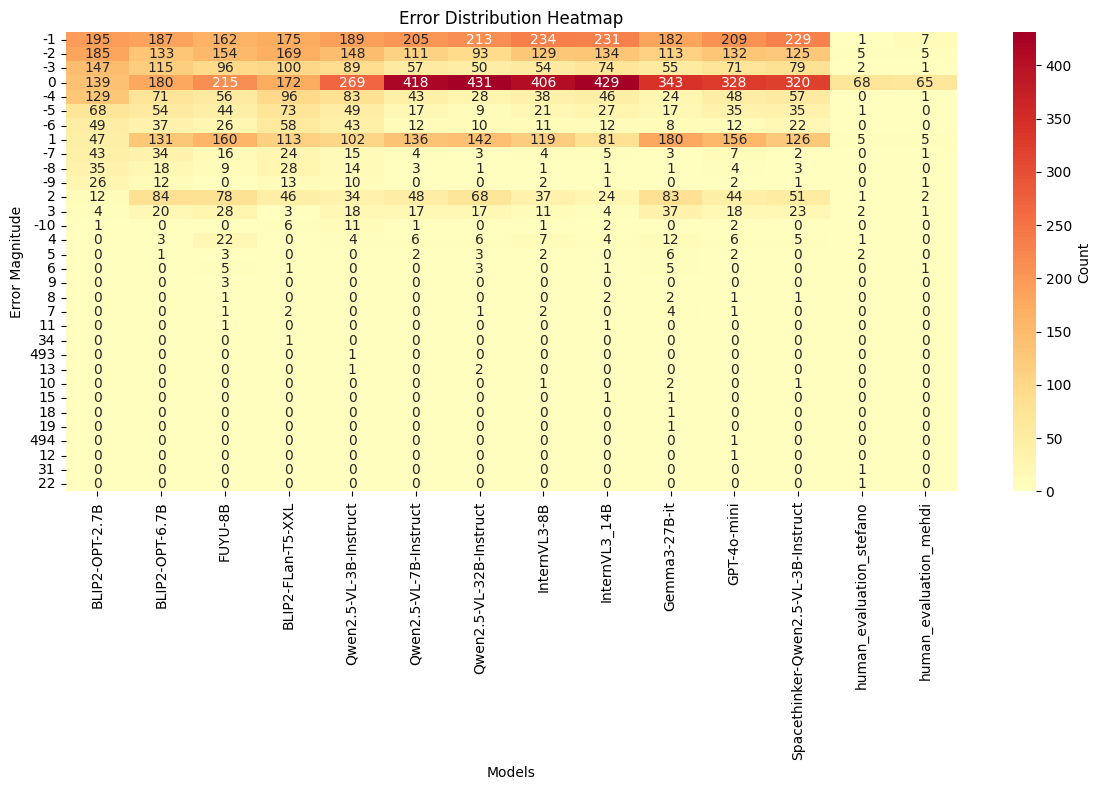

In [14]:
def plot_error_heatmap(model_results_dict):
    """Create a heatmap showing error distribution across categories."""
    plt.figure(figsize=(12, 8))

    # Prepare data for heatmap
    error_counts = {}
    for model, results in model_results_dict.items():
        errors = results['error_distribution']['error_distribution']
        # Count occurrences of each error value
        error_counts[model] = pd.Series(errors).value_counts().to_dict()
    
    # Convert to DataFrame
    error_df = pd.DataFrame(error_counts).fillna(0)
    
    sns.heatmap(error_df, cmap='RdYlBu_r', center=0, 
                annot=True, fmt='.0f',
                cbar_kws={'label': 'Count'})
    
    plt.title('Error Distribution Heatmap')
    plt.xlabel('Models')
    plt.ylabel('Error Magnitude')
    plt.tight_layout()

plot_error_heatmap(model_results)

In [15]:
# def plot_radar_metrics(model_results_dict):
#     """Create a radar plot comparing multiple metrics across models."""
#     metrics = ['MAE', 'MSE', 'RMSE', 'Accuracy']
#     angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    
#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
#     for model, results in model_results_dict.items():
#         values = [
#             results['overall_error_metrics']['MAE'],
#             results['overall_error_metrics']['MSE'],
#             results['overall_error_metrics']['RMSE'],
#             results['overall']
#         ]
#         # Normalize values for better visualization
#         values = [v/max(values) for v in values]
#         ax.plot(angles, values, label=model)
#         ax.fill(angles, values, alpha=0.25)
    
#     ax.set_xticks(angles)
#     ax.set_xticklabels(metrics)
#     ax.set_title('Model Performance Radar Plot')
#     plt.legend(bbox_to_anchor=(1.3, 0.3))
#     plt.tight_layout()

# plot_radar_metrics(model_results)

In [16]:
# def plot_error_bubbles(model_results_dict):
#     """Create a bubble plot showing error distribution."""
#     plt.figure(figsize=(12, 8))
    
#     for model, results in model_results_dict.items():
#         errors = results['error_distribution']['error_distribution']
#         error_counts = pd.Series(errors).value_counts()
        
#         plt.scatter(error_counts.index, 
#                    [model] * len(error_counts),
#                    s=error_counts.values * 100,
#                    alpha=0.6,
#                    label=model)
    
#     plt.title('Error Distribution Bubble Plot')
#     plt.xlabel('Error Magnitude')
#     plt.ylabel('Models')
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()

# plot_error_bubbles(model_results)

In [17]:
# # Error analysis using seaborn
# def plot_error_analysis(model_results_dict):
#     """Create alternative error analysis plots using seaborn."""
#     # Create a figure with multiple subplots
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
#     # 1. Violin Plot for Error Distribution
#     error_data = []
#     model_names = []
#     for model, results in model_results_dict.items():
#         errors = results['error_distribution']['error_distribution']
#         error_data.extend(errors)
#         model_names.extend([model] * len(errors))
    
#     error_df = pd.DataFrame({
#         'Error': error_data,
#         'Model': model_names
#     })
    
#     sns.violinplot(data=error_df, x='Model', y='Error', ax=ax1)
#     ax1.set_title('Error Distribution by Model')
#     ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
#     # 2. Box Plot for Error Metrics
#     metrics_data = []
#     for model, results in model_results_dict.items():
#         metrics = results['overall_error_metrics']
#         for metric, value in metrics.items():
#             if metric != 'category' and metric != 'sample_size':
#                 metrics_data.append({
#                     'Model': model,
#                     'Metric': metric,
#                     'Value': value
#                 })
    
#     metrics_df = pd.DataFrame(metrics_data)
#     sns.boxplot(data=metrics_df, x='Model', y='Value', hue='Metric', ax=ax2)
#     ax2.set_title('Error Metrics Distribution')
#     ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
#     # 3. KDE Plot for Error Distribution
#     sns.kdeplot(data=error_df, x='Error', hue='Model', ax=ax3)
#     ax3.set_title('Error Distribution Density')
    
#     # 4. Swarm Plot for Error Distribution
#     sns.swarmplot(data=error_df, x='Model', y='Error', ax=ax4)
#     ax4.set_title('Error Distribution by Model')
#     ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
#     plt.tight_layout()
#     # plt.savefig('error_analysis_alternative.png', bbox_inches='tight', dpi=300)
#     # plt.close()

# plot_error_analysis(model_results)

In [18]:
# def plot_accuracy_analysis(model_results_dict):
#     """Create accuracy analysis plots."""
#     # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     # 1. Cumulative Accuracy Plot
#     plt.figure(figsize=(10, 6))
    
#     for model, results in model_results_dict.items():
#         off_by_n = results['off_by_n']
#         # Get the maximum N from the available keys
#         max_n = max([int(k.split('_')[-1]) for k in off_by_n.keys() if k.startswith('off_by_')])
#         tolerances = list(range(max_n + 1))
#         accuracies = [off_by_n[f'off_by_{i}'] for i in range(max_n + 1)]
        
#         plt.plot(tolerances, accuracies, marker='o', label=model)

#     # Add baseline markers
#     baseline_colors = ['darkred', 'darkred', 'darkred']  # Same color for all baselines
#     baseline_styles = ['--', ':', '-.']  # Different line styles
#     baseline_labels = ['Random Baseline', 'Off-by-1 Baseline', 'Off-by-2 Baseline']
#     baseline_values = [0.0909, 0.2562, 0.4050]  # Your baseline values
    
#     for value, style, label, color in zip(baseline_values, baseline_styles, baseline_labels, baseline_colors):
#         plt.axhline(y=value, color=color, linestyle=style, alpha=0.5, label=label)
    
#     plt.title('Cumulative Accuracy by Tolerance')
#     plt.xlabel('Tolerance (N)')
#     plt.ylabel('Cumulative Accuracy')
#     plt.grid(True, alpha=0.3)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     # plt.savefig('cumulative_accuracy.png', bbox_inches='tight', dpi=300)
#     # plt.close()
    
#     # 2. Accuracy Distribution by Category
#     plt.figure(figsize=(10, 6))
    
#     categories = ['Direct Recognition', 'Property Inference', 'Counterfactual']
#     x = np.arange(len(categories))
#     width = 0.8 / len(model_results_dict)
    
#     for i, (model, results) in enumerate(model_results_dict.items()):
#         accuracies = [results['question_type'][cat] for cat in categories]
#         plt.bar(x + i*width, accuracies, width, label=model)
    
#     plt.title('Accuracy Distribution by Question Type')
#     plt.xticks(x + width * (len(model_results_dict)-1)/2, categories)
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     # plt.savefig('accuracy_by_question_type.png', bbox_inches='tight', dpi=300)
#     # plt.close()

# plot_accuracy_analysis(model_results)

In [19]:
# ... existing code ...

def calculate_human_average_accuracy():
    """
    Calculate the average accuracy between the two human evaluators for each tolerance level.
    """
    import json
    import pandas as pd
    
    # Load the human evaluation data
    with open('ORBIT_results/human_evaluation_stefano.json', 'r') as f:
        stefano_data = json.load(f)
    
    with open('ORBIT_results/human_evaluation_mehdi.json', 'r') as f:
        mehdi_data = json.load(f)
    
    # Create DataFrames for easier comparison
    stefano_df = pd.DataFrame(stefano_data)
    mehdi_df = pd.DataFrame(mehdi_data)
    
    # Merge the dataframes on the key fields to match corresponding entries
    merged_df = pd.merge(
        stefano_df, 
        mehdi_df, 
        on=['image_id', 'question_id', 'image_type', 'question', 'ground_truth', 'property_category'],
        suffixes=('_stefano', '_mehdi')
    )
    
    # Convert to numeric
    merged_df['ground_truth'] = merged_df['ground_truth'].astype(int)
    merged_df['model_answer_stefano'] = merged_df['model_answer_stefano'].astype(int)
    merged_df['model_answer_mehdi'] = merged_df['model_answer_mehdi'].astype(int)
    
    # Calculate off-by-n accuracies for each human evaluator
    def calculate_off_by_n_for_human(predictions, ground_truths, n=2):
        """Calculate off-by-n accuracy for human evaluator."""
        correct_by_tolerance = {}
        for tolerance in range(n + 1):
            correct = sum(1 for p, g in zip(predictions, ground_truths) if abs(p - g) <= tolerance)
            accuracy = correct / len(predictions)
            correct_by_tolerance[f'off_by_{tolerance}'] = accuracy
        return correct_by_tolerance
    
    # Calculate for Stefano
    stefano_off_by_n = calculate_off_by_n_for_human(
        merged_df['model_answer_stefano'], 
        merged_df['ground_truth']
    )
    
    # Calculate for Mehdi
    mehdi_off_by_n = calculate_off_by_n_for_human(
        merged_df['model_answer_mehdi'], 
        merged_df['ground_truth']
    )
    
    # Calculate average between the two evaluators
    human_average_off_by_n = {}
    for tolerance in range(3):  # 0, 1, 2
        stefano_acc = stefano_off_by_n[f'off_by_{tolerance}']
        mehdi_acc = mehdi_off_by_n[f'off_by_{tolerance}']
        average_acc = (stefano_acc + mehdi_acc) / 2
        human_average_off_by_n[f'off_by_{tolerance}'] = average_acc
    
    print("Human Evaluator Accuracies:")
    print(f"Stefano: {stefano_off_by_n}")
    print(f"Mehdi: {mehdi_off_by_n}")
    print(f"Average: {human_average_off_by_n}")
    
    return human_average_off_by_n

def plot_accuracy_analysis_with_human(model_results_dict, selected_models=None):
    """Create cumulative accuracy plot including human evaluator average."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Get human average accuracy
    human_average = calculate_human_average_accuracy()

    # Choose models to plot (in order)
    if selected_models is None:
        # Default: plot all models
        selected_models = list(model_results_dict.keys())
    # Define marker styles for up to 4 models
    marker_styles = ['o', 's', '^', 'D', 'P', '*', 'X', 'v']
    # If more models than markers, cycle through
    marker_map = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(selected_models)}

    plt.figure(figsize=(10, 6))

    # Plot model results
    for model in selected_models:
        if model not in model_results_dict:
            continue
        results = model_results_dict[model]
        off_by_n = results['off_by_n']
        max_n = max([int(k.split('_')[-1]) for k in off_by_n.keys() if k.startswith('off_by_')])
        tolerances = list(range(max_n + 1))
        accuracies = [off_by_n[f'off_by_{i}'] * 100 for i in range(max_n + 1)]  # Convert to percentage

        plt.plot(
            tolerances, accuracies,
            marker=marker_map[model],
            label=model,
            linewidth=2,
            markersize=8
        )

    # Plot human average as a proper line
    human_tolerances = [0, 1, 2]  # Tolerance values
    human_accuracies = [human_average[f'off_by_{i}'] * 100 for i in range(3)]  # Convert to percentage
    
    plt.plot(
        human_tolerances, human_accuracies,
        marker='*',  # Star marker for human
        label='Human (Average)',
        linewidth=2,
        markersize=8,
        color='#FF1493',  # Bright pink
        alpha=0.8
    )

    # Baseline markers
    baseline_colors = ['red', 'red', 'red']
    baseline_styles = ['--', ':', '-.']
    baseline_labels = ['Random Baseline', 'Off-by-1 Baseline', 'Off-by-2 Baseline']
    baseline_values = [0.0909, 0.2562, 0.4050]  # As fractions

    for value, style, label, color in zip(baseline_values, baseline_styles, baseline_labels, baseline_colors):
        plt.axhline(y=value * 100, color=color, linestyle=style, alpha=0.5, label=label)

    plt.title('Cumulative Accuracy by Tolerance (Including Human Evaluators)')
    plt.xlabel('Tolerance (N)')
    plt.ylabel('Cumulative Accuracy (%)')
    plt.ylim(0, 100)
    plt.xticks([0, 1, 2])
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.show()
    plt.savefig('cumulative_accuracy_with_human.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
# Only plot these models (change as needed)
selected_models = [
    # 'Qwen2.5-VL-7B-Instruct_fp16',
    # 'InternVL3-8B_fp16',
    # 'InternVL2.5-8B-MPO_fp16',
    'FUYU-8B',
    'Qwen2.5-VL-32B-Instruct',
    # 'InternVL3_14B',
    # 'Gemma3-27B-it',
    'GPT-4o-mini'
    # 'Gemini2_0Flash'
]

# Use the new function that includes human evaluators
plot_accuracy_analysis_with_human(model_results, selected_models=selected_models)

Human Evaluator Accuracies:
Stefano: {'off_by_0': 0.7555555555555555, 'off_by_1': 0.8222222222222222, 'off_by_2': 0.8888888888888888}
Mehdi: {'off_by_0': 0.7222222222222222, 'off_by_1': 0.8555555555555555, 'off_by_2': 0.9333333333333333}
Average: {'off_by_0': 0.7388888888888889, 'off_by_1': 0.8388888888888888, 'off_by_2': 0.9111111111111111}



Question Distribution by Property Category:
                   Count  Percentage
property_category                   
taxonomic            333       30.83
relational           283       26.20
physical             244       22.59
functional           220       20.37


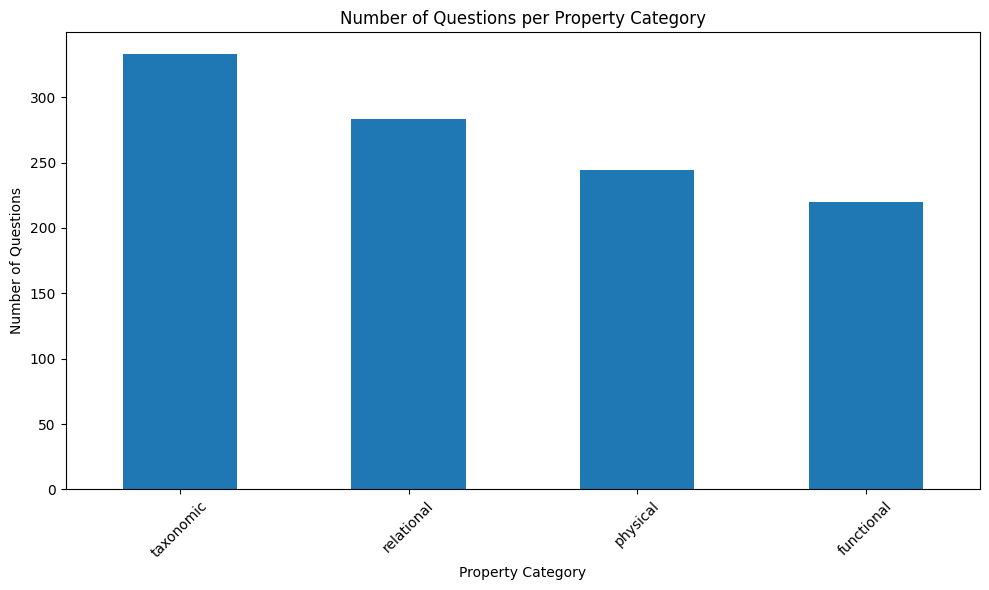

In [20]:
def analyze_question_distribution(results_file):
    """Analyze the distribution of questions across property categories."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Count questions per property category
    property_counts = df['property_category'].value_counts()
    
    # Calculate percentages
    property_percentages = (property_counts / len(df) * 100).round(2)
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Count': property_counts,
        'Percentage': property_percentages
    })
    
    print("\nQuestion Distribution by Property Category:")
    print(summary_df)
    
    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    property_counts.plot(kind='bar')
    plt.title('Number of Questions per Property Category')
    plt.xlabel('Property Category')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return summary_df

# Usage:
distribution = analyze_question_distribution('/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_8b.json')


Property Type Distribution by Question Type:
property_category   functional  physical  relational  taxonomic
question_category                                              
Counterfactual              72       115          71        102
Direct Recognition           0       129           0        231
Property Inference         148         0         212          0

Property Type Distribution by Question Type (Percentage):
property_category   functional  physical  relational  taxonomic
question_category                                              
Counterfactual           20.00     31.94       19.72      28.33
Direct Recognition        0.00     35.83        0.00      64.17
Property Inference       41.11      0.00       58.89       0.00


(property_category   functional  physical  relational  taxonomic
 question_category                                              
 Counterfactual              72       115          71        102
 Direct Recognition           0       129           0        231
 Property Inference         148         0         212          0,
 property_category   functional   physical  relational  taxonomic
 question_category                                               
 Counterfactual       20.000000  31.944444   19.722222  28.333333
 Direct Recognition    0.000000  35.833333    0.000000  64.166667
 Property Inference   41.111111   0.000000   58.888889   0.000000)

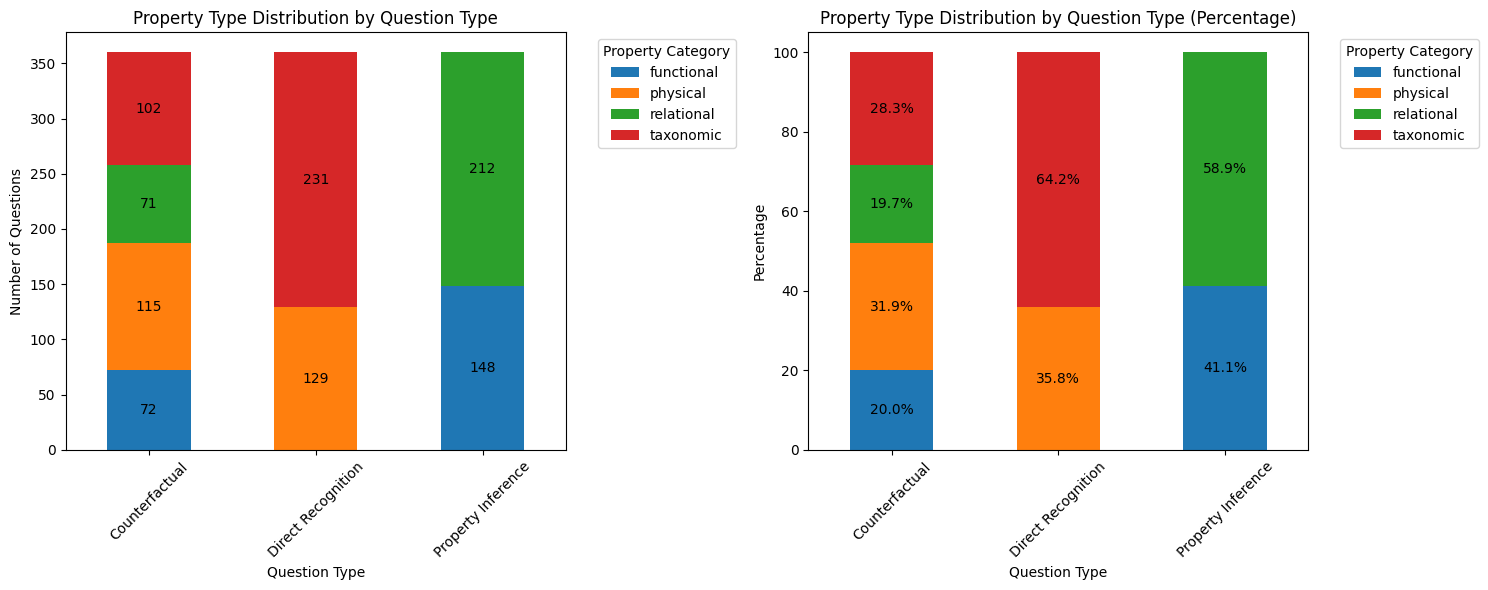

In [21]:
def plot_property_distribution_by_question_type(results_file):
    """Analyze and plot the distribution of property types across question types."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Create mapping from question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    
    # Add question category column based on question_id
    df['question_category'] = df['question_id'].map(question_category_map)

    # Create a cross-tabulation of question types and property categories
    cross_tab = pd.crosstab(df['question_category'], df['property_category'])
    
    # Calculate percentages for each question type
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Property Type Distribution by Question Type')
    ax1.set_xlabel('Question Type')
    ax1.set_ylabel('Number of Questions')
    ax1.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels to the stacked bars
    for c in ax1.containers:
        labels = [f'{int(v)}' if v > 0 else '' for v in c.datavalues]
        ax1.bar_label(c, labels=labels, label_type='center')
    
    # 2. Stacked percentage bar chart
    cross_tab_pct.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Property Type Distribution by Question Type (Percentage)')
    ax2.set_xlabel('Question Type')
    ax2.set_ylabel('Percentage')
    ax2.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels to the stacked bars
    for c in ax2.containers:
        labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
        ax2.bar_label(c, labels=labels, label_type='center')
    
    plt.tight_layout()
    # plt.savefig('property_distribution_by_question_type.png', bbox_inches='tight', dpi=300)
    # plt.close()

    # Print the numerical distribution
    print("\nProperty Type Distribution by Question Type:")
    print(cross_tab)
    print("\nProperty Type Distribution by Question Type (Percentage):")
    print(cross_tab_pct.round(2))
    
    return cross_tab, cross_tab_pct

plot_property_distribution_by_question_type('/var/scratch/ave303/OP_bench/ORBIT_results/InternVL3_results_8b.json')

In [22]:
def analyze_accuracy_by_property_and_question(results_file):
    """Analyze accuracy distribution across both property categories and question types."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Create mapping from question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    
    # Add question category column based on question_id
    df['question_category'] = df['question_id'].map(question_category_map)
    
    # Calculate accuracy for each combination of question type and property category
    accuracy_data = []
    
    for q_type in df['question_category'].unique():
        for p_type in df['property_category'].unique():
            subset = df[(df['question_category'] == q_type) & (df['property_category'] == p_type)]
            if len(subset) > 0:
                correct = sum(subset['model_answer'] == subset['ground_truth'])
                total = len(subset)
                accuracy = correct / total if total > 0 else 0
                accuracy_data.append({
                    'Question Type': q_type,
                    'Property Category': p_type,
                    'Accuracy': accuracy,
                    'Count': total,
                    'Correct': correct
                })
    
    # Convert to DataFrame
    accuracy_df = pd.DataFrame(accuracy_data)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot
    sns.barplot(data=accuracy_df, 
                x='Question Type', 
                y='Accuracy', 
                hue='Property Category',
                palette='Set2')
    
    plt.title('Accuracy by Question Type and Property Category')
    plt.xlabel('Question Type')
    plt.ylabel('Accuracy')
    plt.legend(title='Property Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add count annotations
    for i, row in accuracy_df.iterrows():
        plt.text(i % 3, row['Accuracy'], 
                f'n={row["Count"]}\n({row["Correct"]}/{row["Count"]})',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('accuracy_by_property_and_question.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print detailed statistics
    print("\nDetailed Accuracy Analysis:")
    print("\nAccuracy by Question Type and Property Category:")
    print(accuracy_df.to_string(index=False))
    
    # Calculate weighted averages
    weighted_avg = accuracy_df.groupby('Question Type').apply(
        lambda x: sum(x['Accuracy'] * x['Count']) / sum(x['Count'])
    )
    print("\nWeighted Average Accuracy by Question Type:")
    print(weighted_avg)
    
    return accuracy_df

In [23]:
# accuracy_analysis1 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL2.5_results_8bMPO.json')

In [24]:
# accuracy_analysis2 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL3_results_8b.json')

In [25]:
# accuracy_analysis3 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Qwen2.5-VL_7b_results.json')

In [26]:
# accuracy_analysis4 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/InternVL3_results_14b.json')

In [27]:
# accuracy_analysis5 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Qwen2.5-VL_32b_results.json')

In [28]:
# accuracy_analysis6 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/Spacethinker_Qwen2.5-VL_3b_results.json')

In [29]:
accuracy_analysis7 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')


Detailed Accuracy Analysis:

Accuracy by Question Type and Property Category:
     Question Type Property Category  Accuracy  Count  Correct
Direct Recognition          physical  0.255814    129       33
Direct Recognition         taxonomic  0.385281    231       89
Property Inference        functional  0.304054    148       45
Property Inference        relational  0.391509    212       83
    Counterfactual          physical  0.269565    115       31
    Counterfactual        functional  0.250000     72       18
    Counterfactual        relational  0.253521     71       18
    Counterfactual         taxonomic  0.254902    102       26

Weighted Average Accuracy by Question Type:
Question Type
Counterfactual        0.258333
Direct Recognition    0.338889
Property Inference    0.355556
dtype: float64


/tmp/ipykernel_952707/2758041512.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg = accuracy_df.groupby('Question Type').apply(


In [30]:
# accuracy_analysis8 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results.json')

In [31]:
# accuracy_analysis9 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemini2_0Flash_results1.json')

In [32]:
# accuracy_analysis10 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results_1.json')

In [33]:
# accuracy_analysis11 = analyze_accuracy_by_property_and_question('/var/scratch/ave303/OP_bench/new_results/Qwen2.5-VL_3b_results.json')

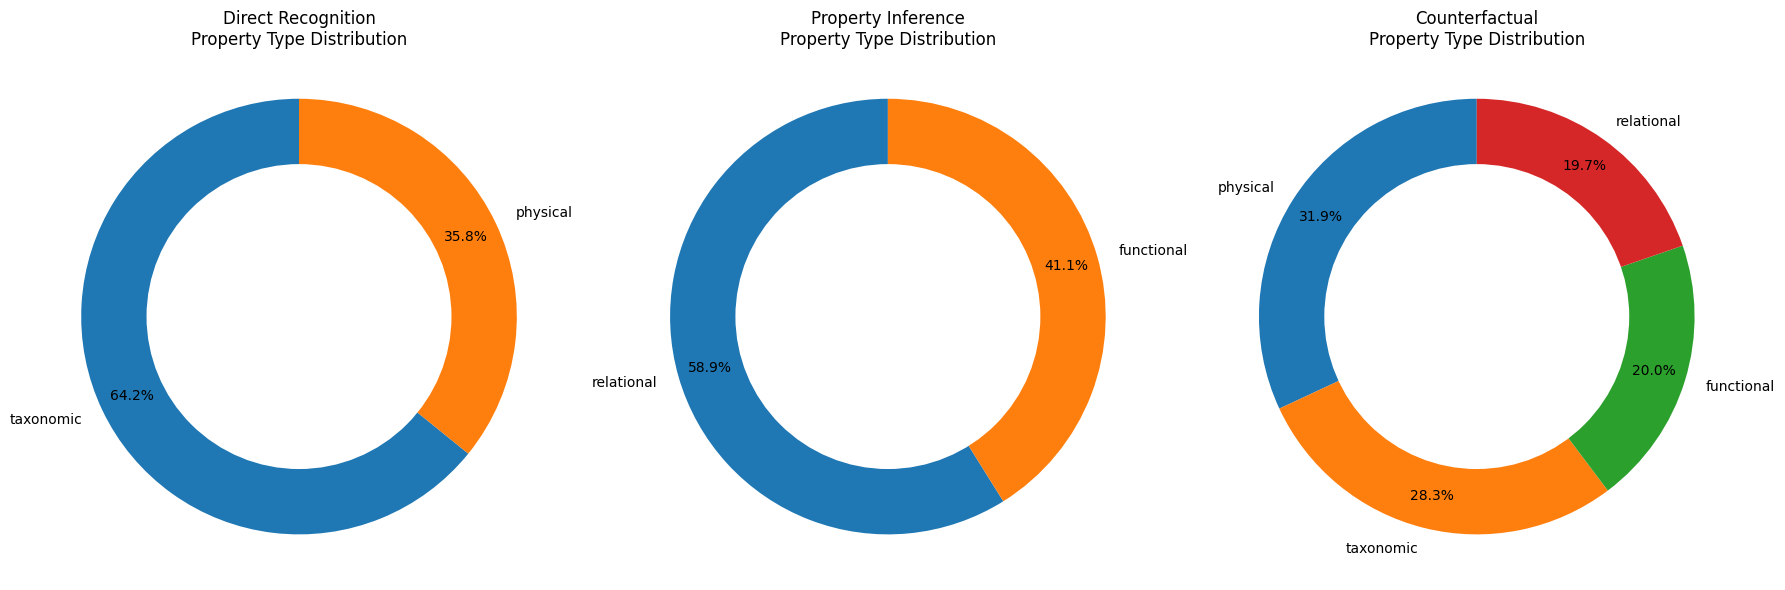

In [34]:
def plot_property_donut_by_question_type(results_file):
    """Plot donut charts of property type distribution for each question type."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Map question_id to question category
    question_category_map = {
        'Q1': 'Direct Recognition',
        'Q2': 'Property Inference',
        'Q3': 'Counterfactual'
    }
    df['question_category'] = df['question_id'].map(question_category_map)
    
    property_categories = df['property_category'].unique()
    question_types = df['question_category'].unique()
    
    fig, axes = plt.subplots(1, len(question_types), figsize=(6 * len(question_types), 6))
    if len(question_types) == 1:
        axes = [axes]
    
    for ax, qtype in zip(axes, question_types):
        counts = df[df['question_category'] == qtype]['property_category'].value_counts()
        labels = counts.index
        sizes = counts.values
        wedges, texts, autotexts = ax.pie(
            sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85
        )
        # Draw a circle at the center to make it a donut
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        ax.add_artist(centre_circle)
        ax.set_title(f"{qtype}\nProperty Type Distribution")
        ax.axis('equal')
    
    plt.tight_layout()
    plt.show()

plot_property_donut_by_question_type('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')

In [35]:
# def plot_nested_donut(results_file):
#     """Plot a nested donut chart for question type and property type composition."""
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     # Map question_id to question category
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Outer ring: property_category, Inner ring: question_category
#     outer_labels = []
#     outer_sizes = []
#     inner_labels = []
#     inner_sizes = []
    
#     for qtype in df['question_category'].unique():
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         for ptype, count in subdf['property_category'].value_counts().items():
#             outer_labels.append(f"{qtype}\n{ptype}")
#             outer_sizes.append(count)
    
#     # Colors
#     cmap = plt.get_cmap("tab20c")
#     outer_colors = cmap(np.arange(len(outer_labels)))
#     inner_colors = cmap(np.arange(len(inner_labels))*4)
    
#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.pie(inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
#     ax.pie(outer_sizes, labels=outer_labels, radius=1.3, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
#     ax.set(aspect="equal")
#     plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.show()

# plot_nested_donut('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [36]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_nested_donut_with_labels(results_file):
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Prepare data
#     inner_labels = []
#     inner_sizes = []
#     outer_labels = []
#     outer_sizes = []
#     outer_pct_labels = []
#     color_base = plt.get_cmap("tab10")
#     color_light = plt.get_cmap("Pastel1")
#     color_map = {}
    
#     for i, qtype in enumerate(df['question_category'].unique()):
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         color_map[qtype] = color_base(i)
#         for j, (ptype, count) in enumerate(subdf['property_category'].value_counts().items()):
#             outer_labels.append(f"{ptype}")
#             outer_sizes.append(count)
#             pct = 100 * count / len(subdf)
#             outer_pct_labels.append(f"{count} ({pct:.1f}%)")
    
#     # Colors: inner ring solid, outer ring lighter
#     inner_colors = [color_map[qtype] for qtype in inner_labels]
#     outer_colors = []
#     for qtype in df['question_category'].unique():
#         c = color_map[qtype]
#         # Make lighter for outer ring
#         outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
#     fig, ax = plt.subplots(figsize=(9, 7))
#     wedges1, _ = ax.pie(inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, 
#                         wedgeprops=dict(width=0.3, edgecolor='w'), labeldistance=0.7)
#     wedges2, _ = ax.pie(outer_sizes, labels=outer_labels, radius=1.3, colors=outer_colors, 
#                         wedgeprops=dict(width=0.3, edgecolor='w'), labeldistance=1.05)
    
#     # Add value labels to outer wedges
#     for i, w in enumerate(wedges2):
#         ang = (w.theta2 - w.theta1)/2. + w.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#         ax.annotate(outer_pct_labels[i], xy=(x*1.45, y*1.45), ha=horizontalalignment, va='center', fontsize=10, fontweight='bold')
    
#     # plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.tight_layout()
#     plt.show()

# plot_nested_donut_with_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [37]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_nested_donut_with_inside_labels(results_file):
#     results = load_results(results_file)
#     df = pd.DataFrame(results)
    
#     question_category_map = {
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference',
#         'Q3': 'Counterfactual'
#     }
#     df['question_category'] = df['question_id'].map(question_category_map)
    
#     # Prepare data
#     inner_labels = []
#     inner_sizes = []
#     outer_labels = []
#     outer_sizes = []
#     outer_pct_labels = []
#     color_base = plt.get_cmap("tab10")
#     color_map = {}
    
#     for i, qtype in enumerate(df['question_category'].unique()):
#         subdf = df[df['question_category'] == qtype]
#         inner_labels.append(qtype)
#         inner_sizes.append(len(subdf))
#         color_map[qtype] = color_base(i)
#         for ptype, count in subdf['property_category'].value_counts().items():
#             outer_labels.append(ptype)
#             outer_sizes.append(count)
#             pct = 100 * count / len(subdf)
#             outer_pct_labels.append(f"{pct:.1f}%")
    
#     # Colors: inner ring solid, outer ring lighter
#     inner_colors = [color_map[qtype] for qtype in inner_labels]
#     outer_colors = []
#     for qtype in df['question_category'].unique():
#         c = color_map[qtype]
#         # Make lighter for outer ring
#         outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
#     fig, ax = plt.subplots(figsize=(8, 7))
#     # Make the rings wider and the center smaller
#     wedges1, _ = ax.pie(
#         inner_sizes, labels=inner_labels, radius=1, colors=inner_colors, 
#         wedgeprops=dict(width=0.45, edgecolor='w'), labeldistance=0.5
#     )
#     wedges2, _ = ax.pie(
#         outer_sizes, labels=None, radius=1.45, colors=outer_colors, 
#         wedgeprops=dict(width=0.45, edgecolor='w')
#     )
    
#     # Place percentage labels inside the outer wedges
#     for i, w in enumerate(wedges2):
#         ang = (w.theta2 - w.theta1)/2. + w.theta1
#         y = np.sin(np.deg2rad(ang))
#         x = np.cos(np.deg2rad(ang))
#         ax.text(
#             x*1.25, y*1.25, outer_pct_labels[i],
#             ha='center', va='center', fontsize=11, fontweight='bold', color='black'
#         )
    
#     plt.title("Nested Donut: Question Type and Property Type Composition")
#     plt.tight_layout()
#     plt.show()

# plot_nested_donut_with_inside_labels('/var/scratch/ave303/OP_bench/new_results/Gemma3_27b_results.json')

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_nested_donut_with_all_labels(results_file):
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    question_category_map = {
        'Q1': 'Direct \nRecognition',
        'Q2': 'Property \nInference',
        'Q3': 'Counterfactual'
    }
    df['question_category'] = df['question_id'].map(question_category_map)
    
    # Prepare data
    inner_labels = []
    inner_sizes = []
    outer_labels = []
    outer_sizes = []
    outer_pct_labels = []
    color_base = plt.get_cmap("tab10")
    color_map = {}
    outer_label_map = []
    
    for i, qtype in enumerate(df['question_category'].unique()):
        subdf = df[df['question_category'] == qtype]
        inner_labels.append(qtype)
        inner_sizes.append(len(subdf))
        color_map[qtype] = color_base(i)
        for ptype, count in subdf['property_category'].value_counts().items():
            outer_labels.append(ptype)
            outer_sizes.append(count)
            pct = 100 * count / len(subdf)
            outer_pct_labels.append(f"{ptype}\n{pct:.1f}%")
            outer_label_map.append(qtype)
    
    # Colors: inner ring solid, outer ring lighter
    inner_colors = [color_map[qtype] for qtype in inner_labels]
    outer_colors = []
    for qtype in df['question_category'].unique():
        c = color_map[qtype]
        # Make lighter for outer ring
        outer_colors.extend([tuple(np.array(c)*0.6 + 0.4) for _ in df[df['question_category']==qtype]['property_category'].value_counts()])
    
    fig, ax = plt.subplots(figsize=(8, 7))
    # Make the rings wider and the center smaller
    wedges1, _ = ax.pie(
        inner_sizes, labels=None, radius=1, colors=inner_colors, 
        wedgeprops=dict(width=0.45, edgecolor='w')
    )
    wedges2, _ = ax.pie(
        outer_sizes, labels=None, radius=1.45, colors=outer_colors, 
        wedgeprops=dict(width=0.45, edgecolor='w')
    )
    
    # Place inner ring labels (question types)
    for i, w in enumerate(wedges1):
        ang = (w.theta2 - w.theta1)/2. + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x*0.75, y*0.75, inner_labels[i],
            ha='center', va='center', fontsize=9.5, fontweight='bold', color='white'
        )
    
    # Place outer ring labels (property type + percentage)
    for i, w in enumerate(wedges2):
        ang = (w.theta2 - w.theta1)/2. + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x*1.22, y*1.22, outer_pct_labels[i],
            ha='center', va='center', fontsize=8.5, fontweight='bold', color='black'
        )
    
    # plt.title("Nested Donut: Question Type and Property Type Composition")
    ax.text(0, 0, "ORBIT\nComposition", ha='center', va='center', fontsize=15, fontweight='bold', color='black')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'benchmark_composition.png', bbox_inches='tight', dpi=300)
    plt.close()

plot_nested_donut_with_all_labels('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')

In [39]:
def plot_ground_truth_distribution(results_file):
    """Plot the distribution of ground truth counts from 0-10."""
    results = load_results(results_file)
    df = pd.DataFrame(results)

    # Convert ground_truth to integer
    df['ground_truth'] = df['ground_truth'].astype(int)

    # Count occurrences of each ground truth value
    gt_counts = df['ground_truth'].value_counts().sort_index()
    
    # Create a complete range from 0-10, filling missing values with 0
    complete_range = pd.Series(index=range(11), data=0)
    complete_range.update(gt_counts)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(complete_range.index, complete_range.values, 
                   color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Y-axis: whole numbers only
    plt.gca().yaxis.get_major_locator().set_params(integer=True)
    
    plt.title('Distribution of Ground Truth Counts (0-10)', fontsize=14, fontweight='bold')
    plt.xlabel('Ground Truth Count', fontsize=12)
    plt.ylabel('Number of Questions', fontsize=12)
    plt.xticks(range(11))
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add total count annotation
    total_questions = len(df)
    plt.text(0.02, 0.98, f'Total Questions: {total_questions}', 
             transform=plt.gca().transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'Ground_truth_dist.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print the numerical distribution
    print("\nGround Truth Count Distribution:")
    print("Count | Number of Questions | Percentage")
    print("-" * 40)
    for count in range(11):
        num_questions = complete_range[count]
        percentage = (num_questions / total_questions) * 100
        print(f"{count:5d} | {num_questions:18d} | {percentage:8.1f}%")
    
    return complete_range

# Usage example:
plot_ground_truth_distribution('/var/scratch/ave303/OP_bench/ORBIT_results/Gemma3_27b_results.json')


Ground Truth Count Distribution:
Count | Number of Questions | Percentage
----------------------------------------
    0 |                 23 |      2.1%
    1 |                124 |     11.5%
    2 |                198 |     18.3%
    3 |                192 |     17.8%
    4 |                172 |     15.9%
    5 |                123 |     11.4%
    6 |                 90 |      8.3%
    7 |                 45 |      4.2%
    8 |                 50 |      4.6%
    9 |                 34 |      3.1%
   10 |                 29 |      2.7%


0      23
1     124
2     198
3     192
4     172
5     123
6      90
7      45
8      50
9      34
10     29
dtype: int64

In [40]:
import json
import matplotlib.pyplot as plt

def count_consistent_outputs(results_file, values_to_check):
    """Count how many times each value appears in the 'model_answer' field."""
    with open(results_file, 'r') as f:
        data = json.load(f)
    counts = {str(v): 0 for v in values_to_check}
    for entry in data:
        model_answer = str(entry.get('model_answer', '')).strip()
        for v in values_to_check:
            if model_answer == str(v):
                counts[str(v)] += 1
    return counts

def plot_consistent_output_distribution_from_json(model_files, model_value_map):
    # Color map for values
    value_color_map = {
        '1': ("#a6cee3", "#1f78b4"),  # light blue, dark blue
        '3': ("#b2df8a", "#33a02c"),  # light green, dark green
        '0': ("#fdbf6f", "#ff7f00")   # light orange, dark orange
    }
    bar_labels = []
    bar_heights = []
    bar_colors = []
    bar_edgecolors = []
    legend_handles = {}
    x_positions = []
    xpos = 0

    for model, (file, values) in model_value_map.items():
        counts = count_consistent_outputs(file, values)
        for v in values:
            v_str = str(v)
            bar_labels.append(model if len(values) == 1 else f"{model}\n({v})")
            bar_heights.append(counts[v_str])
            color, edgecolor = value_color_map[v_str]
            bar_colors.append(color)
            bar_edgecolors.append(edgecolor)
            if v_str not in legend_handles:
                legend_handles[v_str] = plt.Rectangle((0,0),1,1,fc=color,ec=edgecolor)
            x_positions.append(xpos)
            xpos += 1

    plt.figure(figsize=(8, 6))
    bars = plt.bar(x_positions, bar_heights, color=bar_colors, edgecolor=bar_edgecolors, width=0.6)
    plt.xticks(x_positions, bar_labels, fontsize=12)
    plt.ylabel("Number of Questions", fontsize=13)
    plt.xlabel("Models", fontsize=13)
    plt.title("BLIP2 series Inductive Bias", fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # Legend
    plt.legend([legend_handles[v] for v in legend_handles],
               [f"Output value = {v}" for v in legend_handles],
               title="Consistent Output Value", loc='upper right')

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'BLIP2_inductive_bias.png', bbox_inches='tight', dpi=300)
    plt.close()

# Example usage:
model_value_map = {
    "BLIP2-OPT-2.7B": ("/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-2.7b_results.json", [1]),
    "BLIP2-OPT-6.7B": ("/var/scratch/ave303/OP_bench/ORBIT_results/blip2-opt-6.7b_results.json", [1, 3]),
    "BLIP2-Flan-T5-XXL": ("/var/scratch/ave303/OP_bench/ORBIT_results/blip2-flan-t5-xxl_results.json", [0])
}
plot_consistent_output_distribution_from_json(model_value_map, model_value_map)

In [41]:
def calculate_accuracy_per_count(results_file, model_name):
    """Calculate accuracy for each ground truth count (0-10)."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Convert to numeric
    df['ground_truth'] = df['ground_truth'].astype(int)
    df['model_answer'] = df['model_answer'].astype(int)
    
    # Calculate accuracy for each count
    accuracy_per_count = {}
    macro_accuracy = 0
    valid_counts = 0
    
    for count in range(11):  # 0 to 10
        subset = df[df['ground_truth'] == count]
        if len(subset) > 0:
            correct = sum(subset['model_answer'] == subset['ground_truth'])
            accuracy = correct / len(subset)
            accuracy_per_count[count] = {
                'accuracy': accuracy,
                'total_questions': len(subset),
                'correct_answers': correct
            }
            macro_accuracy += accuracy
            valid_counts += 1
        else:
            accuracy_per_count[count] = {
                'accuracy': 0,
                'total_questions': 0,
                'correct_answers': 0
            }
    
    # Calculate macro-accuracy (average of accuracies per count)
    macro_accuracy = macro_accuracy / valid_counts if valid_counts > 0 else 0
    
    return accuracy_per_count, macro_accuracy

In [42]:
def plot_accuracy_per_count_top_models(model_results_dict, top_models):
    """Create a line plot showing accuracy per count for the top models."""
    plt.figure(figsize=(12, 8))
    
    # Define colors and markers for the top models
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
    markers = ['o', 's', '^']
    
    for i, model in enumerate(top_models):
        if model in model_results_dict:
            results = model_results_dict[model]
            file_path = result_files[model]
            accuracy_per_count, _ = calculate_accuracy_per_count(file_path, model)
            
            counts = list(accuracy_per_count.keys())
            accuracies = [accuracy_per_count[count]['accuracy'] * 100 for count in counts]
            
            plt.plot(counts, accuracies, 
                    marker=markers[i], 
                    linewidth=2, 
                    markersize=8,
                    color=colors[i],
                    label=model)
    
    plt.xlabel('Ground Truth Count', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Accuracy per Count for Top Models', fontsize=14, fontweight='bold')
    plt.xticks(range(11))
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig('accuracy_per_count_top_models.png', bbox_inches='tight', dpi=300)
    plt.close()

In [43]:
def create_macro_accuracy_table(model_results_dict):
    """Create a table with macro-accuracy for all models."""
    macro_accuracy_data = []
    
    for model in model_results_dict.keys():
        file_path = result_files[model]
        _, macro_accuracy = calculate_accuracy_per_count(file_path, model)
        
        # Also get overall accuracy for comparison
        results = model_results_dict[model]
        overall_accuracy = results['overall']
        
        macro_accuracy_data.append({
            'Model': model,
            'Macro-Accuracy': macro_accuracy * 100,
            'Overall Accuracy': overall_accuracy * 100
        })
    
    # Create DataFrame and sort by macro-accuracy
    macro_df = pd.DataFrame(macro_accuracy_data)
    macro_df = macro_df.sort_values('Macro-Accuracy', ascending=False)
    
    # Format the table
    print("\nMacro-Accuracy Table (Average of Accuracies per Count):")
    print("=" * 80)
    print(f"{'Model':<35} {'Macro-Accuracy':<15} {'Overall Accuracy':<15}")
    print("-" * 80)
    
    for _, row in macro_df.iterrows():
        print(f"{row['Model']:<35} {row['Macro-Accuracy']:<15.2f}% {row['Overall Accuracy']:<15.2f}%")
    
    # Create detailed table with accuracy per count for all models
    detailed_data = []
    for model in model_results_dict.keys():
        file_path = result_files[model]
        accuracy_per_count, _ = calculate_accuracy_per_count(file_path, model)
        
        row_data = {'Model': model}
        for count in range(11):
            acc = accuracy_per_count[count]['accuracy'] * 100
            row_data[f'Count_{count}'] = acc
        detailed_data.append(row_data)
    
    detailed_df = pd.DataFrame(detailed_data)
    
    # Add macro-accuracy column
    detailed_df['Macro-Avg'] = detailed_df[[f'Count_{i}' for i in range(11)]].mean(axis=1)
    
    # Sort by macro-average
    detailed_df = detailed_df.sort_values('Macro-Avg', ascending=False)
    
    print("\nDetailed Accuracy per Count Table:")
    print("=" * 120)
    
    # Print header
    header = "Model" + "".join([f"{i:>8}" for i in range(11)]) + "  Macro-Avg"
    print(header)
    print("-" * 120)
    
    # Print data rows
    for _, row in detailed_df.iterrows():
        model_name = row['Model'][:20] + "..." if len(row['Model']) > 20 else row['Model']
        counts_str = "".join([f"{row[f'Count_{i}']:>8.1f}" for i in range(11)])
        macro_avg = f"{row['Macro-Avg']:>9.1f}"
        print(f"{model_name:<25} {counts_str} {macro_avg}")
    
    return macro_df, detailed_df

In [44]:
# Execute the analysis
print("Creating accuracy per count analysis...")

# 1. Plot for top 3 models
top_models = ['Qwen2.5-VL-32B-Instruct', 'InternVL3_14B', 'Qwen2.5-VL-7B-Instruct']
plot_accuracy_per_count_top_models(model_results, top_models)
print("✓ Created accuracy per count plot for top models")

Creating accuracy per count analysis...


✓ Created accuracy per count plot for top models


In [45]:
# 2. Create macro-accuracy table for all models
macro_df, detailed_df = create_macro_accuracy_table(model_results)
print("✓ Created macro-accuracy table for all models")

print("\nAnalysis complete! Check the generated files:")
print("- accuracy_per_count_top_models.png")
print("- Macro-accuracy results printed above")


Macro-Accuracy Table (Average of Accuracies per Count):
Model                               Macro-Accuracy  Overall Accuracy
--------------------------------------------------------------------------------
human_evaluation_stefano            75.15          % 75.56          %
human_evaluation_mehdi              67.27          % 72.22          %
Qwen2.5-VL-32B-Instruct             34.46          % 39.91          %
Qwen2.5-VL-7B-Instruct              31.57          % 38.70          %
InternVL3-8B                        31.30          % 37.59          %
InternVL3_14B                       29.90          % 39.72          %
Spacethinker-Qwen2.5-VL-3B-Instruct 25.32          % 29.63          %
Gemma3-27B-it                       24.43          % 31.76          %
Qwen2.5-VL-3B-Instruct              23.55          % 24.91          %
GPT-4o-mini                         22.74          % 30.37          %
BLIP2-FLan-T5-XXL                   12.95          % 15.93          %
FUYU-8B                


Detailed Accuracy per Count Table:
Model       0       1       2       3       4       5       6       7       8       9      10  Macro-Avg
------------------------------------------------------------------------------------------------------------------------
human_evaluation_ste...        0.0   100.0    76.5    71.4    44.4    90.0    72.7    50.0    71.4    75.0   100.0      68.3
human_evaluation_meh...        0.0    88.9    82.4    92.9    44.4    60.0    72.7    25.0    71.4    75.0    60.0      61.2
Qwen2.5-VL-32B-Instr...       87.0    51.6    61.1    43.8    37.8    27.6    28.9     6.7    16.0    11.8     6.9      34.5
Qwen2.5-VL-7B-Instru...       65.2    48.4    61.6    22.4    65.7    31.7    12.2     8.9     8.0     5.9    17.2      31.6
InternVL3-8B                  78.3    62.1    53.0    50.0    32.6    19.5    18.9    11.1    10.0     8.8     0.0      31.3
InternVL3_14B                 56.5    68.5    69.7    49.0    33.7    13.8    18.9     4.4     2.0     8.8     3.

In [46]:
def analyze_property_dimension_accuracy_per_count(results_file, model_name):
    """
    Analyze accuracy per count for each property dimension.
    
    Args:
        results_file: Path to the results JSON file
        model_name: Name of the model for labeling
        
    Returns:
        Dictionary containing analysis for each property dimension
    """
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Convert to numeric
    df['ground_truth'] = df['ground_truth'].astype(int)
    df['model_answer'] = df['model_answer'].astype(int)
    
    # Get unique property categories
    property_categories = df['property_category'].unique()
    
    analysis_results = {}
    
    for prop_category in property_categories:
        subset = df[df['property_category'] == prop_category]
        
        # Count distribution for this property
        count_distribution = subset['ground_truth'].value_counts().sort_index()
        
        # Accuracy per count for this property
        accuracy_per_count = {}
        total_questions = len(subset)
        correct_total = sum(subset['model_answer'] == subset['ground_truth'])
        overall_accuracy = correct_total / total_questions if total_questions > 0 else 0
        
        for count in range(11):  # 0 to 10
            count_subset = subset[subset['ground_truth'] == count]
            if len(count_subset) > 0:
                correct = sum(count_subset['model_answer'] == count_subset['ground_truth'])
                accuracy = correct / len(count_subset)
                accuracy_per_count[count] = {
                    'accuracy': accuracy,
                    'total_questions': len(count_subset),
                    'correct_answers': correct,
                    'percentage_of_property': (len(count_subset) / total_questions) * 100
                }
            else:
                accuracy_per_count[count] = {
                    'accuracy': 0,
                    'total_questions': 0,
                    'correct_answers': 0,
                    'percentage_of_property': 0
                }
        
        # Calculate macro-accuracy for this property (average of accuracies per count)
        valid_counts = sum(1 for count_data in accuracy_per_count.values() if count_data['total_questions'] > 0)
        macro_accuracy = sum(count_data['accuracy'] for count_data in accuracy_per_count.values() if count_data['total_questions'] > 0) / valid_counts if valid_counts > 0 else 0
        
        analysis_results[prop_category] = {
            'total_questions': total_questions,
            'overall_accuracy': overall_accuracy,
            'macro_accuracy': macro_accuracy,
            'count_distribution': count_distribution,
            'accuracy_per_count': accuracy_per_count,
            'correct_total': correct_total
        }
    
    return analysis_results

def plot_property_dimension_analysis(analysis_results, model_name):
    """
    Create comprehensive plots for property dimension analysis.
    
    Args:
        analysis_results: Results from analyze_property_dimension_accuracy_per_count
        model_name: Name of the model for the plot title
    """
    property_categories = list(analysis_results.keys())
    n_properties = len(property_categories)
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))
    
    # Define colors for property categories
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    
    # 1. Count Distribution by Property (top left)
    ax1 = plt.subplot(2, 3, 1)
    for i, prop in enumerate(property_categories):
        count_dist = analysis_results[prop]['count_distribution']
        plt.bar(count_dist.index + i*0.2, count_dist.values, 
                width=0.2, label=prop, color=colors[i], alpha=0.8)
    
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Number of Questions')
    plt.title('Count Distribution by Property Category')
    plt.legend()
    plt.xticks(range(11))
    plt.grid(True, alpha=0.3)
    
    # 2. Accuracy per Count by Property (top middle)
    ax2 = plt.subplot(2, 3, 2)
    for i, prop in enumerate(property_categories):
        acc_data = analysis_results[prop]['accuracy_per_count']
        counts = list(acc_data.keys())
        accuracies = [acc_data[count]['accuracy'] * 100 for count in counts]
        plt.plot(counts, accuracies, marker='o', linewidth=2, 
                markersize=6, label=prop, color=colors[i])
    
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Count by Property Category')
    plt.legend()
    plt.xticks(range(11))
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # 3. Overall vs Macro Accuracy Comparison (top right)
    ax3 = plt.subplot(2, 3, 3)
    overall_accs = [analysis_results[prop]['overall_accuracy'] * 100 for prop in property_categories]
    macro_accs = [analysis_results[prop]['macro_accuracy'] * 100 for prop in property_categories]
    
    x = np.arange(len(property_categories))
    width = 0.35
    
    plt.bar(x - width/2, overall_accs, width, label='Overall Accuracy', alpha=0.8)
    plt.bar(x + width/2, macro_accs, width, label='Macro Accuracy', alpha=0.8)
    
    plt.xlabel('Property Category')
    plt.ylabel('Accuracy (%)')
    plt.title('Overall vs Macro Accuracy by Property')
    plt.xticks(x, property_categories, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Heatmap of Accuracy per Count (bottom left)
    ax4 = plt.subplot(2, 3, 4)
    heatmap_data = []
    for prop in property_categories:
        acc_data = analysis_results[prop]['accuracy_per_count']
        row = [acc_data[count]['accuracy'] * 100 for count in range(11)]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=property_categories, columns=range(11))
    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Accuracy (%)'})
    plt.title('Accuracy Heatmap: Property × Count')
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Property Category')
    
    # 5. Question Distribution Pie Chart (bottom middle)
    ax5 = plt.subplot(2, 3, 5)
    total_questions = [analysis_results[prop]['total_questions'] for prop in property_categories]
    plt.pie(total_questions, labels=property_categories, autopct='%1.1f%%', 
            colors=colors[:len(property_categories)], startangle=90)
    plt.title('Question Distribution by Property Category')
    
    # 6. Accuracy vs Count Distribution Scatter (bottom right)
    ax6 = plt.subplot(2, 3, 6)
    for i, prop in enumerate(property_categories):
        acc_data = analysis_results[prop]['accuracy_per_count']
        counts = []
        accuracies = []
        percentages = []
        
        for count in range(11):
            if acc_data[count]['total_questions'] > 0:
                counts.append(count)
                accuracies.append(acc_data[count]['accuracy'] * 100)
                percentages.append(acc_data[count]['percentage_of_property'])
        
        # Size of points based on percentage of questions
        sizes = [p * 10 for p in percentages]  # Scale for visibility
        
        plt.scatter(counts, accuracies, s=sizes, alpha=0.7, 
                   label=prop, color=colors[i])
    
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Count (Point Size = % of Property Questions)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name}: Property Dimension Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{model_name}_property_dimension_analysis.png', bbox_inches='tight', dpi=300)
    plt.close()

def print_property_dimension_summary(analysis_results, model_name):
    """
    Print a detailed summary of the property dimension analysis.
    
    Args:
        analysis_results: Results from analyze_property_dimension_accuracy_per_count
        model_name: Name of the model
    """
    print(f"\n{'='*80}")
    print(f"PROPERTY DIMENSION ANALYSIS: {model_name}")
    print(f"{'='*80}")
    
    # Summary table
    print("\nSUMMARY TABLE:")
    print(f"{'Property':<15} {'Total Q':<8} {'Overall Acc':<12} {'Macro Acc':<12} {'Correct':<8}")
    print("-" * 70)
    
    for prop in analysis_results.keys():
        data = analysis_results[prop]
        print(f"{prop:<15} {data['total_questions']:<8} {data['overall_accuracy']*100:<11.1f}% {data['macro_accuracy']*100:<11.1f}% {data['correct_total']:<8}")
    
    # Detailed analysis for each property
    for prop in analysis_results.keys():
        data = analysis_results[prop]
        print(f"\n{'-'*40}")
        print(f"DETAILED ANALYSIS: {prop}")
        print(f"{'-'*40}")
        print(f"Total Questions: {data['total_questions']}")
        print(f"Overall Accuracy: {data['overall_accuracy']*100:.1f}%")
        print(f"Macro Accuracy: {data['macro_accuracy']*100:.1f}%")
        print(f"Correct Answers: {data['correct_total']}")
        
        print(f"\nCount Distribution:")
        print(f"{'Count':<6} {'Questions':<10} {'Accuracy':<10} {'% of Property':<15}")
        print("-" * 45)
        
        for count in range(11):
            count_data = data['accuracy_per_count'][count]
            if count_data['total_questions'] > 0:
                print(f"{count:<6} {count_data['total_questions']:<10} {count_data['accuracy']*100:<9.1f}% {count_data['percentage_of_property']:<14.1f}%")
        
        # Identify best and worst performing counts
        valid_counts = [(count, data['accuracy_per_count'][count]) 
                       for count in range(11) 
                       if data['accuracy_per_count'][count]['total_questions'] > 0]
        
        if valid_counts:
            best_count = max(valid_counts, key=lambda x: x[1]['accuracy'])
            worst_count = min(valid_counts, key=lambda x: x[1]['accuracy'])
            
            print(f"\nBest performing count: {best_count[0]} (Accuracy: {best_count[1]['accuracy']*100:.1f}%)")
            print(f"Worst performing count: {worst_count[0]} (Accuracy: {worst_count[1]['accuracy']*100:.1f}%)")

def compare_property_dimensions_across_models(result_files):
    """
    Compare property dimension performance across multiple models.
    
    Args:
        result_files: Dictionary of model names to file paths
    """
    print(f"\n{'='*100}")
    print("CROSS-MODEL PROPERTY DIMENSION COMPARISON")
    print(f"{'='*100}")
    
    # Collect data for comparison
    comparison_data = []
    
    for model_name, file_path in result_files.items():
        if Path(file_path).exists():
            prop_analysis = analyze_property_dimension_accuracy_per_count(file_path, model_name)
            
            for prop_category in prop_analysis.keys():
                data = prop_analysis[prop_category]
                comparison_data.append({
                    'Model': model_name,
                    'Property': prop_category,
                    'Total_Questions': data['total_questions'],
                    'Overall_Accuracy': data['overall_accuracy'] * 100,
                    'Macro_Accuracy': data['macro_accuracy'] * 100,
                    'Correct_Answers': data['correct_total']
                })
    
    # Create comparison DataFrame
    comp_df = pd.DataFrame(comparison_data)
    
    # Print summary table
    print("\nPROPERTY DIMENSION PERFORMANCE ACROSS MODELS:")
    print(f"{'Model':<25} {'Property':<12} {'Overall':<8} {'Macro':<8} {'Questions':<10}")
    print("-" * 70)
    
    for _, row in comp_df.iterrows():
        print(f"{row['Model']:<25} {row['Property']:<12} {row['Overall_Accuracy']:<7.1f}% {row['Macro_Accuracy']:<7.1f}% {row['Total_Questions']:<10}")
    
    # Create heatmap for macro accuracy
    plt.figure(figsize=(12, 8))
    pivot_df = comp_df.pivot(index='Model', columns='Property', values='Macro_Accuracy')
    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Macro Accuracy (%)'})
    plt.title('Macro Accuracy by Property Dimension Across Models')
    plt.tight_layout()
    plt.savefig('property_dimension_comparison_heatmap.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    return comp_df

# Execute the analysis for a specific model
def run_property_dimension_analysis(model_name):
    """
    Run complete property dimension analysis for a specific model.
    
    Args:
        model_name: Name of the model to analyze
    """
    if model_name not in result_files:
        print(f"Model {model_name} not found in result_files")
        return
    
    file_path = result_files[model_name]
    print(f"Analyzing property dimensions for {model_name}...")
    
    # Run analysis
    analysis_results = analyze_property_dimension_accuracy_per_count(file_path, model_name)
    
    # Create plots
    plot_property_dimension_analysis(analysis_results, model_name)
    
    # Print summary
    print_property_dimension_summary(analysis_results, model_name)
    
    print(f"\n✓ Analysis complete for {model_name}")
    print(f"✓ Generated plot: {model_name}_property_dimension_analysis.png")

# Or analyze all models
def analyze_all_models_property_dimensions():
    """Analyze property dimensions for all models."""
    for model_name in result_files.keys():
        if Path(result_files[model_name]).exists():
            run_property_dimension_analysis(model_name)
    
    # Create cross-model comparison
    comp_df = compare_property_dimensions_across_models(result_files)
    print("\n✓ Cross-model comparison complete")
    print("✓ Generated plot: property_dimension_comparison_heatmap.png")

# Execute the analysis
print("Starting property dimension analysis...")
analyze_all_models_property_dimensions()

Starting property dimension analysis...
Analyzing property dimensions for BLIP2-OPT-2.7B...



PROPERTY DIMENSION ANALYSIS: BLIP2-OPT-2.7B

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      11.5       % 9.4        % 28      
functional      220      10.9       % 6.9        % 24      
relational      283      13.8       % 8.3        % 39      
taxonomic       333      14.4       % 13.2       % 48      

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 11.5%
Macro Accuracy: 9.4%
Correct Answers: 28

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          14.3     % 2.9           %
1      27         63.0     % 11.1          %
2      35         17.1     % 14.3          %
3      43         7.0      % 17.6          %
4      51         2.0      % 20.9          %
5      18         0.0      % 7.4  


PROPERTY DIMENSION ANALYSIS: BLIP2-OPT-6.7B

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      16.4       % 9.6        % 40      
functional      220      14.1       % 8.4        % 31      
relational      283      19.1       % 10.7       % 54      
taxonomic       333      16.5       % 9.7        % 55      

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 16.4%
Macro Accuracy: 9.6%
Correct Answers: 40

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          0.0      % 2.9           %
1      27         33.3     % 11.1          %
2      35         5.7      % 14.3          %
3      43         65.1     % 17.6          %
4      51         2.0      % 20.9          %
5      18         0.0      % 7.4  


PROPERTY DIMENSION ANALYSIS: FUYU-8B

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      17.2       % 13.3       % 42      
functional      220      19.5       % 9.5        % 43      
relational      283      25.4       % 11.9       % 72      
taxonomic       333      17.4       % 11.4       % 58      

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 17.2%
Macro Accuracy: 13.3%
Correct Answers: 42

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          14.3     % 2.9           %
1      27         11.1     % 11.1          %
2      35         51.4     % 14.3          %
3      43         25.6     % 17.6          %
4      51         11.8     % 20.9          %
5      18         0.0      % 7.4        


PROPERTY DIMENSION ANALYSIS: BLIP2-FLan-T5-XXL

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      14.3       % 12.8       % 35      
functional      220      13.6       % 7.0        % 30      
relational      283      18.0       % 18.7       % 51      
taxonomic       333      16.8       % 13.1       % 56      

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 14.3%
Macro Accuracy: 12.8%
Correct Answers: 35

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          57.1     % 2.9           %
1      27         14.8     % 11.1          %
2      35         40.0     % 14.3          %
3      43         20.9     % 17.6          %
4      51         7.8      % 20.9          %
5      18         0.0      % 7


PROPERTY DIMENSION ANALYSIS: Qwen2.5-VL-3B-Instruct

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      21.3       % 19.5       % 52      
functional      220      17.7       % 10.6       % 39      
relational      283      28.3       % 26.7       % 80      
taxonomic       333      29.4       % 27.7       % 98      

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 21.3%
Macro Accuracy: 19.5%
Correct Answers: 52

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          100.0    % 2.9           %
1      27         22.2     % 11.1          %
2      35         22.9     % 14.3          %
3      43         7.0      % 17.6          %
4      51         51.0     % 20.9          %
5      18         0.0    


PROPERTY DIMENSION ANALYSIS: Qwen2.5-VL-7B-Instruct

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      35.7       % 31.8       % 87      
functional      220      32.7       % 24.3       % 72      
relational      283      41.7       % 26.5       % 118     
taxonomic       333      42.3       % 33.8       % 141     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 35.7%
Macro Accuracy: 31.8%
Correct Answers: 87

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          85.7     % 2.9           %
1      27         51.9     % 11.1          %
2      35         54.3     % 14.3          %
3      43         14.0     % 17.6          %
4      51         58.8     % 20.9          %
5      18         16.7   


PROPERTY DIMENSION ANALYSIS: Qwen2.5-VL-32B-Instruct

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      33.6       % 30.7       % 82      
functional      220      38.2       % 31.7       % 84      
relational      283      41.3       % 37.5       % 117     
taxonomic       333      44.4       % 36.9       % 148     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 33.6%
Macro Accuracy: 30.7%
Correct Answers: 82

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          100.0    % 2.9           %
1      27         55.6     % 11.1          %
2      35         40.0     % 14.3          %
3      43         34.9     % 17.6          %
4      51         39.2     % 20.9          %
5      18         11.1  


PROPERTY DIMENSION ANALYSIS: InternVL3-8B

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      33.2       % 29.3       % 81      
functional      220      26.8       % 25.4       % 59      
relational      283      44.2       % 37.4       % 125     
taxonomic       333      42.3       % 34.1       % 141     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 33.2%
Macro Accuracy: 29.3%
Correct Answers: 81

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          85.7     % 2.9           %
1      27         70.4     % 11.1          %
2      35         37.1     % 14.3          %
3      43         53.5     % 17.6          %
4      51         23.5     % 20.9          %
5      18         5.6      % 7.4   


PROPERTY DIMENSION ANALYSIS: InternVL3_14B

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      30.3       % 25.2       % 74      
functional      220      36.8       % 25.9       % 81      
relational      283      40.3       % 21.5       % 114     
taxonomic       333      48.0       % 37.8       % 160     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 30.3%
Macro Accuracy: 25.2%
Correct Answers: 74

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          71.4     % 2.9           %
1      27         70.4     % 11.1          %
2      35         45.7     % 14.3          %
3      43         48.8     % 17.6          %
4      51         15.7     % 20.9          %
5      18         0.0      % 7.4  


PROPERTY DIMENSION ANALYSIS: Gemma3-27B-it

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      26.2       % 23.3       % 64      
functional      220      28.6       % 21.1       % 63      
relational      283      35.7       % 24.5       % 101     
taxonomic       333      34.5       % 26.5       % 115     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 26.2%
Macro Accuracy: 23.3%
Correct Answers: 64

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          71.4     % 2.9           %
1      27         33.3     % 11.1          %
2      35         28.6     % 14.3          %
3      43         46.5     % 17.6          %
4      51         23.5     % 20.9          %
5      18         11.1     % 7.4  


PROPERTY DIMENSION ANALYSIS: GPT-4o-mini

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      21.3       % 17.7       % 52      
functional      220      25.0       % 13.6       % 55      
relational      283      37.8       % 29.6       % 107     
taxonomic       333      34.2       % 27.5       % 114     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 21.3%
Macro Accuracy: 17.7%
Correct Answers: 52

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          57.1     % 2.9           %
1      27         29.6     % 11.1          %
2      35         28.6     % 14.3          %
3      43         41.9     % 17.6          %
4      51         13.7     % 20.9          %
5      18         5.6      % 7.4    


PROPERTY DIMENSION ANALYSIS: Spacethinker-Qwen2.5-VL-3B-Instruct

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
physical        244      25.0       % 20.6       % 61      
functional      220      19.5       % 16.5       % 43      
relational      283      32.5       % 28.0       % 92      
taxonomic       333      37.2       % 31.9       % 124     

----------------------------------------
DETAILED ANALYSIS: physical
----------------------------------------
Total Questions: 244
Overall Accuracy: 25.0%
Macro Accuracy: 20.6%
Correct Answers: 61

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
0      7          100.0    % 2.9           %
1      27         18.5     % 11.1          %
2      35         28.6     % 14.3          %
3      43         4.7      % 17.6          %
4      51         70.6     % 20.9          %
5      18   


PROPERTY DIMENSION ANALYSIS: human_evaluation_stefano

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
taxonomic       25       92.0       % 91.7       % 23      
functional      21       71.4       % 74.5       % 15      
relational      20       80.0       % 82.3       % 16      
physical        24       58.3       % 55.9       % 14      

----------------------------------------
DETAILED ANALYSIS: taxonomic
----------------------------------------
Total Questions: 25
Overall Accuracy: 92.0%
Macro Accuracy: 91.7%
Correct Answers: 23

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
2      5          100.0    % 20.0          %
3      4          75.0     % 16.0          %
4      2          50.0     % 8.0           %
5      4          100.0    % 16.0          %
6      2          100.0    % 8.0           %
7      1          100.0


PROPERTY DIMENSION ANALYSIS: human_evaluation_mehdi

SUMMARY TABLE:
Property        Total Q  Overall Acc  Macro Acc    Correct 
----------------------------------------------------------------------
taxonomic       25       80.0       % 75.6       % 20      
functional      21       76.2       % 82.4       % 16      
relational      20       75.0       % 68.8       % 15      
physical        24       58.3       % 57.8       % 14      

----------------------------------------
DETAILED ANALYSIS: taxonomic
----------------------------------------
Total Questions: 25
Overall Accuracy: 80.0%
Macro Accuracy: 75.6%
Correct Answers: 20

Count Distribution:
Count  Questions  Accuracy   % of Property  
---------------------------------------------
2      5          80.0     % 20.0          %
3      4          100.0    % 16.0          %
4      2          50.0     % 8.0           %
5      4          50.0     % 16.0          %
6      2          100.0    % 8.0           %
7      1          0.0    


PROPERTY DIMENSION PERFORMANCE ACROSS MODELS:
Model                     Property     Overall  Macro    Questions 
----------------------------------------------------------------------
BLIP2-OPT-2.7B            physical     11.5   % 9.4    % 244       
BLIP2-OPT-2.7B            functional   10.9   % 6.9    % 220       
BLIP2-OPT-2.7B            relational   13.8   % 8.3    % 283       
BLIP2-OPT-2.7B            taxonomic    14.4   % 13.2   % 333       
BLIP2-OPT-6.7B            physical     16.4   % 9.6    % 244       
BLIP2-OPT-6.7B            functional   14.1   % 8.4    % 220       
BLIP2-OPT-6.7B            relational   19.1   % 10.7   % 283       
BLIP2-OPT-6.7B            taxonomic    16.5   % 9.7    % 333       
FUYU-8B                   physical     17.2   % 13.3   % 244       
FUYU-8B                   functional   19.5   % 9.5    % 220       
FUYU-8B                   relational   25.4   % 11.9   % 283       
FUYU-8B                   taxonomic    17.4   % 11.4   % 333      


✓ Cross-model comparison complete
✓ Generated plot: property_dimension_comparison_heatmap.png


<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [46]</a>'.</span>

In [47]:
# %pip install plotly
# %pip install umap-learn


In [48]:
# # Import required libraries
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# from sentence_transformers import SentenceTransformer
# # import plotly.express as px

# def analyze_error_clusters(predictions, ground_truths, questions, model_name='all-MiniLM-L6-v2'):
#     """
#     Analyze error patterns using t-SNE and UMAP clustering on question embeddings.
    
#     Args:
#         predictions: List of predicted counts
#         ground_truths: List of ground truth counts
#         questions: List of questions
#         model_name: Name of the sentence transformer model to use
#     """
#     # Convert to numeric values
#     preds = [int(str(p)) for p in predictions]
#     truths = [int(str(g)) for g in ground_truths]
    
#     # Find wrong answers
#     wrong_indices = [i for i, (p, t) in enumerate(zip(preds, truths)) if p != t]
#     wrong_questions = [questions[i] for i in wrong_indices]
#     error_magnitudes = [p - t for i, (p, t) in enumerate(zip(preds, truths)) if i in wrong_indices]
    
#     print(f"Number of wrong answers: {len(wrong_questions)}")
    
#     # Get embeddings for wrong questions
#     print("Generating embeddings...")
#     model = SentenceTransformer(model_name)
#     embeddings = model.encode(wrong_questions)
    
#     # Apply t-SNE
#     print("Applying t-SNE...")
#     tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
#     tsne_results = tsne.fit_transform(embeddings)
    
#     # Apply UMAP
#     print("Applying UMAP...")
#     reducer = umap.UMAP(random_state=42, n_neighbors=min(15, len(embeddings)-1))
#     umap_results = reducer.fit_transform(embeddings)
    
#     # Create plots
#     plt.figure(figsize=(15, 6))

#     # t-SNE plot
#     plt.subplot(1, 2, 1)
#     scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
#                          c=error_magnitudes, cmap='RdBu', alpha=0.6)
#     plt.colorbar(scatter, label='Error Magnitude')
#     plt.title('t-SNE Clustering of Wrong Answers')
#     plt.xlabel('t-SNE 1')
#     plt.ylabel('t-SNE 2')
    
#     # UMAP plot
#     plt.subplot(1, 2, 2)
#     scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], 
#                          c=error_magnitudes, cmap='RdBu', alpha=0.6)
#     plt.colorbar(scatter, label='Error Magnitude')
#     plt.title('UMAP Clustering of Wrong Answers')
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print some statistics about the errors
#     print("\nError Statistics:")
#     print(f"Mean error magnitude: {np.mean(error_magnitudes):.2f}")
#     print(f"Std error magnitude: {np.std(error_magnitudes):.2f}")
#     print(f"Min error: {min(error_magnitudes)}")
#     print(f"Max error: {max(error_magnitudes)}")
    
#     # Return the results for further analysis if needed
#     return {
#         'tsne_results': tsne_results,
#         'umap_results': umap_results,
#         'error_magnitudes': error_magnitudes,
#         'wrong_questions': wrong_questions
#     }

# # Example usage:
# # fig_tsne, fig_umap = analyze_error_clusters(predictions, ground_truths, questions)
# # fig_tsne.show()
# # fig_umap.show()

# for model_name, file_path in result_files.items():
#     if Path(file_path).exists():
#         print(f"\nAnalyzing {model_name}...")
#         results = load_results(file_path)
#         df = pd.DataFrame(results)
#         predictions = df['model_answer']
#         ground_truths = df['ground_truth']
#         questions = df['question']
#         outputs = analyze_error_clusters(predictions, ground_truths, questions)
#         # results = analyze_results(file_path, model_name)
#         # model_results[model_name] = results
#         # plot_results(results, model_name)
#         # fig_tsne.show()
#         # fig_umap.show()
        

In [49]:
def analyze_human_annotator_agreement():
    """
    Analyze agreement between the two human annotators (Stefano and Mehdi).
    """
    import json
    import pandas as pd
    from collections import defaultdict
    
    # Load the human evaluation data
    with open('ORBIT_results/human_evaluation_stefano.json', 'r') as f:
        stefano_data = json.load(f)
    
    with open('ORBIT_results/human_evaluation_mehdi.json', 'r') as f:
        mehdi_data = json.load(f)
    
    # Create DataFrames for easier comparison
    stefano_df = pd.DataFrame(stefano_data)
    mehdi_df = pd.DataFrame(mehdi_data)
    
    # Merge the dataframes on the key fields to match corresponding entries
    merged_df = pd.merge(
        stefano_df, 
        mehdi_df, 
        on=['image_id', 'question_id', 'image_type', 'question', 'ground_truth', 'property_category'],
        suffixes=('_stefano', '_mehdi')
    )
    
    print(f"Total matching entries: {len(merged_df)}")
    
    # Calculate agreement metrics
    agreement_results = {}
    
    # 1. Overall agreement
    exact_agreement = (merged_df['model_answer_stefano'] == merged_df['model_answer_mehdi']).sum()
    overall_agreement = exact_agreement / len(merged_df)
    agreement_results['overall'] = {
        'agreement_rate': overall_agreement,
        'exact_matches': exact_agreement,
        'total_questions': len(merged_df)
    }
    
    print(f"\nOverall Agreement: {overall_agreement:.2%} ({exact_agreement}/{len(merged_df)})")
    
    # 2. Agreement by question type
    question_agreement = {}
    for q_type in merged_df['question_id'].unique():
        subset = merged_df[merged_df['question_id'] == q_type]
        exact_matches = (subset['model_answer_stefano'] == subset['model_answer_mehdi']).sum()
        agreement_rate = exact_matches / len(subset)
        question_agreement[q_type] = {
            'agreement_rate': agreement_rate,
            'exact_matches': exact_matches,
            'total_questions': len(subset)
        }
        print(f"{q_type}: {agreement_rate:.2%} ({exact_matches}/{len(subset)})")
    
    agreement_results['question_type'] = question_agreement
    
    # 3. Agreement by property category
    property_agreement = {}
    for prop_category in merged_df['property_category'].unique():
        subset = merged_df[merged_df['property_category'] == prop_category]
        exact_matches = (subset['model_answer_stefano'] == subset['model_answer_mehdi']).sum()
        agreement_rate = exact_matches / len(subset)
        property_agreement[prop_category] = {
            'agreement_rate': agreement_rate,
            'exact_matches': exact_matches,
            'total_questions': len(subset)
        }
        print(f"{prop_category}: {agreement_rate:.2%} ({exact_matches}/{len(subset)})")
    
    agreement_results['property_category'] = property_agreement
    
    # 4. Agreement by image type
    image_agreement = {}
    for img_type in merged_df['image_type'].unique():
        subset = merged_df[merged_df['image_type'] == img_type]
        exact_matches = (subset['model_answer_stefano'] == subset['model_answer_mehdi']).sum()
        agreement_rate = exact_matches / len(subset)
        image_agreement[img_type] = {
            'agreement_rate': agreement_rate,
            'exact_matches': exact_matches,
            'total_questions': len(subset)
        }
        print(f"{img_type}: {agreement_rate:.2%} ({exact_matches}/{len(subset)})")
    
    agreement_results['image_type'] = image_agreement
    
    # 5. Agreement by ground truth count
    count_agreement = {}
    for count in sorted(merged_df['ground_truth'].unique()):
        subset = merged_df[merged_df['ground_truth'] == count]
        exact_matches = (subset['model_answer_stefano'] == subset['model_answer_mehdi']).sum()
        agreement_rate = exact_matches / len(subset)
        count_agreement[count] = {
            'agreement_rate': agreement_rate,
            'exact_matches': exact_matches,
            'total_questions': len(subset)
        }
        print(f"Count {count}: {agreement_rate:.2%} ({exact_matches}/{len(subset)})")
    
    agreement_results['ground_truth_count'] = count_agreement
    
    # 6. Analyze disagreements
    disagreements = merged_df[merged_df['model_answer_stefano'] != merged_df['model_answer_mehdi']]
    print(f"\nDisagreements: {len(disagreements)}")
    
    if len(disagreements) > 0:
        print("\nSample disagreements:")
        for idx, row in disagreements.head(10).iterrows():
            print(f"Image {row['image_id']}, {row['question_id']}: Stefano={row['model_answer_stefano']}, Mehdi={row['model_answer_mehdi']}, GT={row['ground_truth']}")
    
    # 7. Create visualizations
    create_agreement_visualizations(agreement_results, merged_df)
    
    return agreement_results, merged_df

def create_agreement_visualizations(agreement_results, merged_df):
    """
    Create visualizations for the agreement analysis.
    """
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Agreement by question type
    question_types = list(agreement_results['question_type'].keys())
    question_rates = [agreement_results['question_type'][qt]['agreement_rate'] * 100 for qt in question_types]
    
    bars1 = ax1.bar(question_types, question_rates, color='skyblue', alpha=0.7)
    ax1.set_title('Agreement by Question Type')
    ax1.set_ylabel('Agreement Rate (%)')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, rate in zip(bars1, question_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. Agreement by property category
    property_categories = list(agreement_results['property_category'].keys())
    property_rates = [agreement_results['property_category'][pc]['agreement_rate'] * 100 for pc in property_categories]
    
    bars2 = ax2.bar(property_categories, property_rates, color='lightgreen', alpha=0.7)
    ax2.set_title('Agreement by Property Category')
    ax2.set_ylabel('Agreement Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, rate in zip(bars2, property_rates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 3. Agreement by image type
    image_types = list(agreement_results['image_type'].keys())
    image_rates = [agreement_results['image_type'][it]['agreement_rate'] * 100 for it in image_types]
    
    bars3 = ax3.bar(image_types, image_rates, color='lightcoral', alpha=0.7)
    ax3.set_title('Agreement by Image Type')
    ax3.set_ylabel('Agreement Rate (%)')
    ax3.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, rate in zip(bars3, image_rates):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 4. Agreement by ground truth count
    counts = list(agreement_results['ground_truth_count'].keys())
    count_rates = [agreement_results['ground_truth_count'][c]['agreement_rate'] * 100 for c in counts]
    
    bars4 = ax4.bar(counts, count_rates, color='gold', alpha=0.7)
    ax4.set_title('Agreement by Ground Truth Count')
    ax4.set_xlabel('Ground Truth Count')
    ax4.set_ylabel('Agreement Rate (%)')
    ax4.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, rate in zip(bars4, count_rates):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('human_annotator_agreement.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Create a summary table
    create_agreement_summary_table(agreement_results)

def create_agreement_summary_table(agreement_results):
    """
    Create a summary table of agreement results.
    """
    print(f"\n{'='*80}")
    print("HUMAN ANNOTATOR AGREEMENT SUMMARY")
    print(f"{'='*80}")
    
    # Overall summary
    overall = agreement_results['overall']
    print(f"\nOverall Agreement: {overall['agreement_rate']:.2%}")
    print(f"Exact Matches: {overall['exact_matches']}/{overall['total_questions']}")
    
    # Detailed breakdowns
    print(f"\n{'='*50}")
    print("AGREEMENT BY QUESTION TYPE")
    print(f"{'='*50}")
    for q_type, data in agreement_results['question_type'].items():
        print(f"{q_type}: {data['agreement_rate']:.2%} ({data['exact_matches']}/{data['total_questions']})")
    
    print(f"\n{'='*50}")
    print("AGREEMENT BY PROPERTY CATEGORY")
    print(f"{'='*50}")
    for prop, data in agreement_results['property_category'].items():
        print(f"{prop}: {data['agreement_rate']:.2%} ({data['exact_matches']}/{data['total_questions']})")
    
    print(f"\n{'='*50}")
    print("AGREEMENT BY IMAGE TYPE")
    print(f"{'='*50}")
    for img_type, data in agreement_results['image_type'].items():
        print(f"{img_type}: {data['agreement_rate']:.2%} ({data['exact_matches']}/{data['total_questions']})")
    
    print(f"\n{'='*50}")
    print("AGREEMENT BY GROUND TRUTH COUNT")
    print(f"{'='*50}")
    for count, data in agreement_results['ground_truth_count'].items():
        print(f"Count {count}: {data['agreement_rate']:.2%} ({data['exact_matches']}/{data['total_questions']})")

# Execute the agreement analysis
print("Analyzing human annotator agreement...")
agreement_results, merged_df = analyze_human_annotator_agreement()

print("\n✓ Agreement analysis complete!")
print("✓ Generated plot: human_annotator_agreement.png")

Analyzing human annotator agreement...
Total matching entries: 90

Overall Agreement: 67.78% (61/90)
Q1: 76.67% (23/30)
Q2: 66.67% (20/30)
Q3: 60.00% (18/30)
taxonomic: 80.00% (20/25)
functional: 57.14% (12/21)
relational: 65.00% (13/20)
physical: 66.67% (16/24)
REAL: 60.00% (18/30)
ANIMATED: 76.67% (23/30)
AI_GENERATED: 66.67% (20/30)
Count 1: 88.89% (8/9)
Count 10: 60.00% (3/5)
Count 2: 76.47% (13/17)
Count 3: 64.29% (9/14)
Count 4: 77.78% (7/9)
Count 5: 50.00% (5/10)
Count 6: 63.64% (7/11)
Count 7: 25.00% (1/4)
Count 8: 71.43% (5/7)
Count 9: 75.00% (3/4)

Disagreements: 29

Sample disagreements:
Image image07, Q2: Stefano=4, Mehdi=5, GT=5
Image image08, Q3: Stefano=2, Mehdi=1, GT=2
Image image17, Q2: Stefano=5, Mehdi=4, GT=5
Image image24, Q3: Stefano=5, Mehdi=6, GT=5
Image image26, Q2: Stefano=10, Mehdi=12, GT=10
Image image26, Q3: Stefano=3, Mehdi=2, GT=2
Image image37, Q1: Stefano=6, Mehdi=0, GT=9
Image image37, Q3: Stefano=4, Mehdi=2, GT=6
Image image62, Q3: Stefano=5, Mehdi=6, 


HUMAN ANNOTATOR AGREEMENT SUMMARY

Overall Agreement: 67.78%
Exact Matches: 61/90

AGREEMENT BY QUESTION TYPE
Q1: 76.67% (23/30)
Q2: 66.67% (20/30)
Q3: 60.00% (18/30)

AGREEMENT BY PROPERTY CATEGORY
taxonomic: 80.00% (20/25)
functional: 57.14% (12/21)
relational: 65.00% (13/20)
physical: 66.67% (16/24)

AGREEMENT BY IMAGE TYPE
REAL: 60.00% (18/30)
ANIMATED: 76.67% (23/30)
AI_GENERATED: 66.67% (20/30)

AGREEMENT BY GROUND TRUTH COUNT
Count 1: 88.89% (8/9)
Count 10: 60.00% (3/5)
Count 2: 76.47% (13/17)
Count 3: 64.29% (9/14)
Count 4: 77.78% (7/9)
Count 5: 50.00% (5/10)
Count 6: 63.64% (7/11)
Count 7: 25.00% (1/4)
Count 8: 71.43% (5/7)
Count 9: 75.00% (3/4)

✓ Agreement analysis complete!
✓ Generated plot: human_annotator_agreement.png


In [50]:
# ... existing code ...

def create_theme_composition_donut():
    """
    Create a donut chart showing question composition by image themes from benchmark.json.
    """
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Load the benchmark data
    with open('/var/scratch/ave303/OP_bench/benchmark.json', 'r') as f:
        benchmark_data = json.load(f)
    
    # Extract all images and their themes
    images = benchmark_data['benchmark']['images']
    
    # Count questions per theme
    theme_counts = {}
    for image in images:
        theme = image['theme']
        num_questions = len(image['questions'])
        
        if theme in theme_counts:
            theme_counts[theme] += num_questions
        else:
            theme_counts[theme] = num_questions
    
    # Sort themes by count for better visualization
    sorted_themes = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True)
    themes, counts = zip(*sorted_themes)
    
    # Create the donut chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors for themes
    colors = plt.cm.Set3(np.linspace(0, 1, len(themes)))
    
    # Create the donut chart
    wedges, texts, autotexts = ax.pie(
        counts, 
        labels=themes, 
        autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85,
        colors=colors,
        textprops={'fontsize': 10}
    )
    
    # Draw a circle at the center to make it a donut
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax.add_artist(centre_circle)
    
    # Add title and center text
    ax.set_title('Question Composition by Image Theme', fontsize=16, fontweight='bold', pad=20)
    ax.text(0, 0, f'Total\nQuestions\n{sum(counts)}', 
            ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], label=f'{theme} ({count})') 
                      for i, (theme, count) in enumerate(zip(themes, counts))]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('theme_composition_donut.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Print detailed statistics
    print("Question Composition by Image Theme:")
    print("=" * 50)
    print(f"{'Theme':<20} {'Questions':<10} {'Percentage':<10}")
    print("-" * 50)
    
    total_questions = sum(counts)
    for theme, count in zip(themes, counts):
        percentage = (count / total_questions) * 100
        print(f"{theme:<20} {count:<10} {percentage:<9.1f}%")
    
    print(f"\nTotal Questions: {total_questions}")
    print(f"Total Themes: {len(themes)}")
    
    # Additional analysis by image type
    print("\nTheme Distribution by Image Type:")
    print("=" * 50)
    
    theme_by_type = {}
    for image in images:
        theme = image['theme']
        img_type = image['image_type']
        num_questions = len(image['questions'])
        
        if img_type not in theme_by_type:
            theme_by_type[img_type] = {}
        
        if theme in theme_by_type[img_type]:
            theme_by_type[img_type][theme] += num_questions
        else:
            theme_by_type[img_type][theme] = num_questions
    
    for img_type, themes_dict in theme_by_type.items():
        print(f"\n{img_type}:")
        sorted_themes_type = sorted(themes_dict.items(), key=lambda x: x[1], reverse=True)
        for theme, count in sorted_themes_type:
            print(f"  {theme}: {count} questions")
    
    return theme_counts, theme_by_type

def create_theme_by_image_type_donuts():
    """
    Create separate donut charts for each image type showing theme composition.
    """
    import json
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Load the benchmark data
    with open('/var/scratch/ave303/OP_bench/benchmark.json', 'r') as f:
        benchmark_data = json.load(f)
    
    images = benchmark_data['benchmark']['images']
    
    # Group by image type
    theme_by_type = {}
    for image in images:
        theme = image['theme']
        img_type = image['image_type']
        num_questions = len(image['questions'])
        
        if img_type not in theme_by_type:
            theme_by_type[img_type] = {}
        
        if theme in theme_by_type[img_type]:
            theme_by_type[img_type][theme] += num_questions
        else:
            theme_by_type[img_type][theme] = num_questions
    
    # Create subplots for each image type
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (img_type, themes_dict) in enumerate(theme_by_type.items()):
        ax = axes[i]
        
        # Sort themes by count
        sorted_themes = sorted(themes_dict.items(), key=lambda x: x[1], reverse=True)
        themes, counts = zip(*sorted_themes)
        
        # Define colors
        colors = plt.cm.Set3(np.linspace(0, 1, len(themes)))
        
        # Create donut chart
        wedges, texts, autotexts = ax.pie(
            counts, 
            labels=themes, 
            autopct='%1.1f%%', 
            startangle=90, 
            pctdistance=0.85,
            colors=colors,
            textprops={'fontsize': 9}
        )
        
        # Draw center circle
        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        ax.add_artist(centre_circle)
        
        # Add title and center text
        ax.set_title(f'{img_type} Themes', fontsize=14, fontweight='bold')
        ax.text(0, 0, f'{sum(counts)}\nQuestions', 
                ha='center', va='center', fontsize=12, fontweight='bold')
        
        ax.axis('equal')
    
    plt.tight_layout()
    plt.savefig('theme_composition_by_image_type.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    return theme_by_type

# Execute the analysis
print("Creating theme composition donut chart...")
theme_counts, theme_by_type = create_theme_composition_donut()

print("\nCreating theme composition by image type...")
theme_by_type_detailed = create_theme_by_image_type_donuts()

print("\n✓ Theme composition analysis complete!")
print("✓ Generated plots:")
print("  - theme_composition_donut.png")
print("  - theme_composition_by_image_type.png")

Creating theme composition donut chart...


Question Composition by Image Theme:
Theme                Questions  Percentage
--------------------------------------------------
home setup           114        10.6     %
kitchen              99         9.2      %
meeting room         72         6.7      %
zoo                  66         6.1      %
urban                66         6.1      %
bedroom              66         6.1      %
garage               60         5.6      %
library              51         4.7      %
beach cleanup        48         4.4      %
salon                45         4.2      %
classroom            39         3.6      %
park                 39         3.6      %
wardrobe             36         3.3      %
picnic               36         3.3      %
laboratory           30         2.8      %
construction         27         2.5      %
driveway             27         2.5      %
farm                 27         2.5      %
biking               24         2.2      %
tools                24         2.2      %
gym      


✓ Theme composition analysis complete!
✓ Generated plots:
  - theme_composition_donut.png
  - theme_composition_by_image_type.png


In [51]:
# def analyze_accuracy_by_image_themes():
#     """
#     Analyze question composition and accuracy by image themes for the top model.
#     """
#     import json
#     import pandas as pd
#     import matplotlib.pyplot as plt
#     import seaborn as sns
    
#     # Load the top model results (Qwen2.5-VL-32B) 
#     with open('/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_32b_results.json', 'r') as f:
#         model_data = json.load(f)
    
#     df = pd.DataFrame(model_data)
    
#     # Convert to numeric
#     df['ground_truth'] = df['ground_truth'].astype(int)
#     df['model_answer'] = df['model_answer'].astype(int)
    
#     # Extract theme from image_id (assuming format like "image01", "image02", etc.)
#     # We'll need to map image_id to themes based on the log data
#     theme_mapping = {
#         # REAL themes (22)
#         'image01': 'beach cleanup', 'image02': 'bedroom', 'image03': 'biking', 'image04': 'camping',
#         'image05': 'classroom', 'image06': 'construction', 'image07': 'driveway', 'image08': 'garage',
#         'image09': 'gardening', 'image10': 'gym', 'image11': 'home setup', 'image12': 'kitchen',
#         'image13': 'laboratory', 'image14': 'library', 'image15': 'market', 'image16': 'meeting room',
#         'image17': 'salon', 'image18': 'tech', 'image19': 'tools', 'image20': 'urban',
#         'image21': 'wardrobe', 'image22': 'zoo',
        
#         # ANIMATED themes (20) - continuing from image23
#         'image23': 'beach cleanup', 'image24': 'bedroom', 'image25': 'biking', 'image26': 'classroom',
#         'image27': 'construction', 'image28': 'farm', 'image29': 'garage', 'image30': 'gardening',
#         'image31': 'gym', 'image32': 'home setup', 'image33': 'kitchen', 'image34': 'laboratory',
#         'image35': 'market', 'image36': 'meeting room', 'image37': 'park', 'image38': 'salon',
#         'image39': 'tools', 'image40': 'urban', 'image41': 'wardrobe', 'image42': 'zoo',
        
#         # AI_GENERATED themes (21) - continuing from image43
#         'image43': 'beach cleanup', 'image44': 'bedroom', 'image45': 'biking', 'image46': 'bustop',
#         'image47': 'camping', 'image48': 'classroom', 'image49': 'construction', 'image50': 'driveway',
#         'image51': 'farm', 'image52': 'garage', 'image53': 'gym', 'image54': 'home setup',
#         'image55': 'kitchen', 'image56': 'laboratory', 'image57': 'library', 'image58': 'market',
#         'image59': 'park', 'image60': 'picnic', 'image61': 'tech', 'image62': 'tools', 'image63': 'zoo'
#     }
    
#     # Add theme column
#     df['theme'] = df['image_id'].map(theme_mapping)
    
#     # Remove rows where theme is not found
#     df = df.dropna(subset=['theme'])
    
#     print(f"Total questions with theme mapping: {len(df)}")
#     print(f"Unique themes found: {df['theme'].nunique()}")
    
#     # 1. Question Composition by Theme
#     theme_counts = df['theme'].value_counts()
    
#     plt.figure(figsize=(15, 8))
    
#     # Create subplot for question composition
#     plt.subplot(2, 2, 1)
#     theme_counts.plot(kind='bar', color='skyblue', alpha=0.7)
#     plt.title('Question Composition by Image Theme')
#     plt.xlabel('Theme')
#     plt.ylabel('Number of Questions')
#     plt.xticks(rotation=45, ha='right')
#     plt.grid(True, alpha=0.3)
    
#     # 2. Overall Accuracy by Theme
#     theme_accuracy = df.groupby('theme').apply(
#         lambda x: (x['model_answer'] == x['ground_truth']).sum() / len(x)
#     ).sort_values(ascending=False)
    
#     plt.subplot(2, 2, 2)
#     theme_accuracy.plot(kind='bar', color='green', alpha=0.7)
#     plt.title('Qwen2.5-VL-32B: Overall Accuracy by Theme')
#     plt.xlabel('Theme')
#     plt.ylabel('Accuracy')
#     plt.xticks(rotation=45, ha='right')
#     plt.grid(True, alpha=0.3)
    
#     # # Add value labels on bars
#     # for i, v in enumerate(theme_accuracy):
#     #     plt.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')
    
#     # 3. Accuracy by Theme and Count
#     plt.subplot(2, 2, 3)
    
#     # Create heatmap data
#     theme_count_accuracy = df.groupby(['theme', 'ground_truth']).apply(
#         lambda x: (x['model_answer'] == x['ground_truth']).sum() / len(x)
#     ).unstack(fill_value=0)
    
#     # Plot heatmap
#     sns.heatmap(theme_count_accuracy, annot=True, fmt='.2f', cmap='RdYlBu_r', 
#                 cbar_kws={'label': 'Accuracy'})
#     plt.title('Accuracy by Theme and Ground Truth Count')
#     plt.xlabel('Ground Truth Count')
#     plt.ylabel('Theme')
    
#     # 4. Average Count per Theme
#     avg_count_by_theme = df.groupby('theme')['ground_truth'].mean().sort_values(ascending=False)
    
#     plt.subplot(2, 2, 4)
#     avg_count_by_theme.plot(kind='bar', color='orange', alpha=0.7)
#     plt.title('Average Ground Truth Count by Theme')
#     plt.xlabel('Theme')
#     plt.ylabel('Average Count')
#     plt.xticks(rotation=45, ha='right')
#     plt.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig('accuracy_by_image_themes.png', bbox_inches='tight', dpi=300)
#     plt.close()
    
#     # Print detailed statistics
#     print("\nDetailed Theme Analysis:")
#     print("=" * 80)
#     print(f"{'Theme':<20} {'Questions':<10} {'Accuracy':<10} {'Avg Count':<10}")
#     print("-" * 80)
    
#     for theme in theme_accuracy.index:
#         theme_df = df[df['theme'] == theme]
#         accuracy = theme_accuracy[theme]
#         count = theme_counts[theme]
#         avg_count = theme_df['ground_truth'].mean()
#         print(f"{theme:<20} {count:<10} {accuracy:<9.2%} {avg_count:<9.2f}")
    
#     return df, theme_accuracy, theme_counts

# def create_theme_detailed_analysis():
#     """
#     Create more detailed analysis by theme including question types and property categories.
#     """
#     import json
#     import pandas as pd
#     import matplotlib.pyplot as plt
    
#     # Load the model data
#     with open('/var/scratch/ave303/OP_bench/ORBIT_results/Qwen2.5-VL_32b_results.json', 'r') as f:
#         model_data = json.load(f)
    
#     df = pd.DataFrame(model_data)
    
#     # Add theme mapping (same as above)
#     theme_mapping = {
#         # Add the same mapping as in the previous function
#         'image01': 'beach cleanup', 'image02': 'bedroom', 'image03': 'biking', 'image04': 'camping',
#         'image05': 'classroom', 'image06': 'construction', 'image07': 'driveway', 'image08': 'garage',
#         'image09': 'gardening', 'image10': 'gym', 'image11': 'home setup', 'image12': 'kitchen',
#         'image13': 'laboratory', 'image14': 'library', 'image15': 'market', 'image16': 'meeting room',
#         'image17': 'salon', 'image18': 'tech', 'image19': 'tools', 'image20': 'urban',
#         'image21': 'wardrobe', 'image22': 'zoo',
#         'image23': 'beach cleanup', 'image24': 'bedroom', 'image25': 'biking', 'image26': 'classroom',
#         'image27': 'construction', 'image28': 'farm', 'image29': 'garage', 'image30': 'gardening',
#         'image31': 'gym', 'image32': 'home setup', 'image33': 'kitchen', 'image34': 'laboratory',
#         'image35': 'market', 'image36': 'meeting room', 'image37': 'park', 'image38': 'salon',
#         'image39': 'tools', 'image40': 'urban', 'image41': 'wardrobe', 'image42': 'zoo',
#         'image43': 'beach cleanup', 'image44': 'bedroom', 'image45': 'biking', 'image46': 'bustop',
#         'image47': 'camping', 'image48': 'classroom', 'image49': 'construction', 'image50': 'driveway',
#         'image51': 'farm', 'image52': 'garage', 'image53': 'gym', 'image54': 'home setup',
#         'image55': 'kitchen', 'image56': 'laboratory', 'image57': 'library', 'image58': 'market',
#         'image59': 'park', 'image60': 'picnic', 'image61': 'tech', 'image62': 'tools', 'image63': 'zoo'
#     }
    
#     df['theme'] = df['image_id'].map(theme_mapping)
#     df = df.dropna(subset=['theme'])
    
#     # Add question category
#     df['question_category'] = df['question_id'].map({
#         'Q1': 'Direct Recognition',
#         'Q2': 'Property Inference', 
#         'Q3': 'Counterfactual'
#     })
    
#     # Create detailed analysis plots
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
#     # 1. Accuracy by Theme and Question Type
#     theme_qtype_accuracy = df.groupby(['theme', 'question_category']).apply(
#         lambda x: (x['model_answer'] == x['ground_truth']).sum() / len(x)
#     ).unstack(fill_value=0)
    
#     theme_qtype_accuracy.plot(kind='bar', ax=ax1, width=0.8)
#     ax1.set_title('Accuracy by Theme and Question Type')
#     ax1.set_xlabel('Theme')
#     ax1.set_ylabel('Accuracy')
#     ax1.tick_params(axis='x', rotation=45, ha='right')
#     ax1.legend(title='Question Type')
#     ax1.grid(True, alpha=0.3)
    
#     # 2. Accuracy by Theme and Property Category
#     theme_prop_accuracy = df.groupby(['theme', 'property_category']).apply(
#         lambda x: (x['model_answer'] == x['ground_truth']).sum() / len(x)
#     ).unstack(fill_value=0)
    
#     theme_prop_accuracy.plot(kind='bar', ax=ax2, width=0.8)
#     ax2.set_title('Accuracy by Theme and Property Category')
#     ax2.set_xlabel('Theme')
#     ax2.set_ylabel('Accuracy')
#     ax2.tick_params(axis='x', rotation=45, ha='right')
#     ax2.legend(title='Property Category')
#     ax2.grid(True, alpha=0.3)
    
#     # 3. Question Distribution by Theme
#     theme_qtype_dist = df.groupby(['theme', 'question_category']).size().unstack(fill_value=0)
    
#     theme_qtype_dist.plot(kind='bar', ax=ax3, width=0.8, stacked=True)
#     ax3.set_title('Question Distribution by Theme')
#     ax3.set_xlabel('Theme')
#     ax3.set_ylabel('Number of Questions')
#     ax3.tick_params(axis='x', rotation=45, ha='right')
#     ax3.legend(title='Question Type')
#     ax3.grid(True, alpha=0.3)
    
#     # 4. Property Category Distribution by Theme
#     theme_prop_dist = df.groupby(['theme', 'property_category']).size().unstack(fill_value=0)
    
#     theme_prop_dist.plot(kind='bar', ax=ax4, width=0.8, stacked=True)
#     ax4.set_title('Property Category Distribution by Theme')
#     ax4.set_xlabel('Theme')
#     ax4.set_ylabel('Number of Questions')
#     ax4.tick_params(axis='x', rotation=45, ha='right')
#     ax4.legend(title='Property Category')
#     ax4.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig('theme_detailed_analysis.png', bbox_inches='tight', dpi=300)
#     plt.close()
    
#     return df

# # Execute the analysis
# print("Analyzing accuracy by image themes...")
# df, theme_accuracy, theme_counts = analyze_accuracy_by_image_themes()

# print("\nCreating detailed theme analysis...")
# detailed_df = create_theme_detailed_analysis()

# print("\n✓ Theme analysis complete!")
# print("✓ Generated plots:")
# print("  - accuracy_by_image_themes.png")
# print("  - theme_detailed_analysis.png")

In [52]:
# ... existing code ...

def calculate_human_accuracy_per_count():
    """
    Calculate the average accuracy between the two human evaluators for each specific count.
    """
    import json
    import pandas as pd
    
    # Load the human evaluation data
    with open('ORBIT_results/human_evaluation_stefano.json', 'r') as f:
        stefano_data = json.load(f)
    
    with open('ORBIT_results/human_evaluation_mehdi.json', 'r') as f:
        mehdi_data = json.load(f)
    
    # Create DataFrames for easier comparison
    stefano_df = pd.DataFrame(stefano_data)
    mehdi_df = pd.DataFrame(mehdi_data)
    
    # Merge the dataframes on the key fields to match corresponding entries
    merged_df = pd.merge(
        stefano_df, 
        mehdi_df, 
        on=['image_id', 'question_id', 'image_type', 'question', 'ground_truth', 'property_category'],
        suffixes=('_stefano', '_mehdi')
    )
    
    # Convert to numeric
    merged_df['ground_truth'] = merged_df['ground_truth'].astype(int)
    merged_df['model_answer_stefano'] = merged_df['model_answer_stefano'].astype(int)
    merged_df['model_answer_mehdi'] = merged_df['model_answer_mehdi'].astype(int)
    
    # Calculate accuracy per count for each human evaluator
    def calculate_accuracy_per_count_for_human(df, answer_col):
        """Calculate accuracy for each ground truth count for a human evaluator."""
        accuracy_per_count = {}
        for count in range(11):  # 0 to 10
            subset = df[df['ground_truth'] == count]
            if len(subset) > 0:
                correct = sum(subset[answer_col] == subset['ground_truth'])
                accuracy = correct / len(subset)
                accuracy_per_count[count] = accuracy
            else:
                accuracy_per_count[count] = 0
        return accuracy_per_count
    
    # Calculate for each human evaluator
    stefano_accuracy_per_count = calculate_accuracy_per_count_for_human(merged_df, 'model_answer_stefano')
    mehdi_accuracy_per_count = calculate_accuracy_per_count_for_human(merged_df, 'model_answer_mehdi')
    
    # Calculate average between the two evaluators
    human_average_per_count = {}
    for count in range(11):
        stefano_acc = stefano_accuracy_per_count[count]
        mehdi_acc = mehdi_accuracy_per_count[count]
        average_acc = (stefano_acc + mehdi_acc) / 2
        human_average_per_count[count] = average_acc
    
    print("Human Accuracy per Count:")
    for count in range(11):
        print(f"Count {count}: {human_average_per_count[count]:.2%}")
    
    return human_average_per_count

def plot_accuracy_per_count_top_models(model_results_dict, top_models):
    """Create a line plot showing accuracy per count for the top models and human evaluators."""
    plt.figure(figsize=(12, 8))
    
    # Define colors and markers for the models
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, Purple, Orange
    markers = ['o', 's', '^']
    
    # Plot model results
    for i, model in enumerate(top_models):
        if model in model_results_dict:
            results = model_results_dict[model]
            file_path = result_files[model]
            accuracy_per_count, _ = calculate_accuracy_per_count(file_path, model)
            
            counts = list(accuracy_per_count.keys())
            accuracies = [accuracy_per_count[count]['accuracy'] * 100 for count in counts]
            
            plt.plot(counts, accuracies, 
                    marker=markers[i], 
                    linewidth=2, 
                    markersize=8,
                    color=colors[i],
                    label=model)
    
    # Calculate and plot human average per count
    human_average_per_count = calculate_human_accuracy_per_count()
    human_counts = list(range(11))  # 0 to 10
    human_accuracies = [human_average_per_count[count] * 100 for count in human_counts]  # Convert to percentage
    
    plt.plot(
        human_counts, human_accuracies,
        marker='*',  # Star marker for human
        label='Human (Average)',
        linewidth=2,
        markersize=12,
        color='#FF1493',  # Bright pink
        alpha=0.9
    )
    
    plt.xlabel('Ground Truth Count', fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=16)
    plt.title('Accuracy per Count for Top Models and Human Evaluators', fontsize=18, fontweight='bold')
    plt.xticks(range(11))
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig('accuracy_per_count_top_models_with_human.png', bbox_inches='tight', dpi=300)
    plt.close()

# Execute the analysis
print("Creating accuracy per count plot for top models with human evaluators...")
top_models = ['Qwen2.5-VL-32B-Instruct', 'InternVL3_14B', 'Qwen2.5-VL-7B-Instruct']
plot_accuracy_per_count_top_models(model_results, top_models)
print("✓ Created accuracy per count plot for top models with human evaluators")

Creating accuracy per count plot for top models with human evaluators...


Human Accuracy per Count:
Count 0: 0.00%
Count 1: 94.44%
Count 2: 79.41%
Count 3: 82.14%
Count 4: 44.44%
Count 5: 75.00%
Count 6: 72.73%
Count 7: 37.50%
Count 8: 71.43%
Count 9: 75.00%
Count 10: 80.00%


✓ Created accuracy per count plot for top models with human evaluators
